# SUMMARIZING IMMUNE CELLS
## Sid Gurajala
## Last Updated: 03/21/2024

In [14]:
library(Seurat)
library(dplyr) 
library(tidyr)
library(viridis)
library(stringr)
library(pheatmap)
library(presto)
library(pals)
library(parallel)
library(harmony)
library(cowplot)
library(singlecellmethods)
library(ggplot2)
library(lisi) 
source("/data/srlab/anathan/scripts/scseq_utils.R")
library(parallel)
library('lme4', lib.loc = "/PHShome/ssg34/.conda/envs/jupy/lib/R/library")
library(glmmTMB, lib.loc ="/PHShome/ssg34/.conda/envs/jupy/lib/R/library")
.libPaths("/PHShome/ssg34/.conda/envs/plswork/lib/R/library")


pivot_wilcox_expr <- function(wilcox_obj) {
    df <- wilcox_obj %>% select(group, feature, avgExpr) %>% 
                    pivot_wider(names_from = 'feature', values_from = 'avgExpr') %>% data.frame()
    rownames(df) <- df$group
    df <- df %>% select(-group) %>% as.matrix()
    return(df)
}

pivot_wilcox_logFC <- function(wilcox_obj) {
    df <- wilcox_obj %>% select(group, feature, logFC) %>% 
                    pivot_wider(names_from = 'feature', values_from = 'logFC') %>% data.frame()
    rownames(df) <- df$group
    df <- df %>% select(-group) %>% as.matrix()
    return(df)
}

plot_shuffled_features <- function(input_df, input_norm, feature, pct, pt_size) {
    
max.cutoff = quantile(input_norm[feature, input_df$cell], pct)
min.cutoff = quantile(input_norm[feature, input_df$cell], 1-pct)

plot_df <- input_df 
    
plot_df$norm_expression <- input_norm[feature, input_df$cell]
    
plot_df <- plot_df %>% 
                mutate(norm_expression = ifelse(norm_expression < min.cutoff, min.cutoff, norm_expression)) %>%
                mutate(norm_expression = ifelse(norm_expression > max.cutoff, max.cutoff, norm_expression)) 

p <- ggplot() +
        geom_point(
            data = plot_df[sample(nrow(plot_df)), ] %>% 
                      select(hUMAP1, hUMAP2, norm_expression), 
            aes(x = hUMAP1, y = hUMAP2, color = norm_expression),
            size = pt_size, stroke = 0.0001, shape = 20) +
      scale_color_viridis(name = "Expression") +
      labs(x="", y="", title = feature)+
      theme_classic(base_size = 20)+
      #facet_wrap(~dataset)+
      theme(
        legend.text = element_text(size = 10), 
        legend.title = element_text(size = 12),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=25, face="bold.italic", hjust = 0.5),
        strip.text.x = element_text(size = 18),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          axis.line = element_blank()) 
return(p)
}

vargenes_vst <- function(object, groups, topn, loess.span = 0.3) {
    clip.max <- sqrt(ncol(object))

    N <- ncol(object)
    if (missing(groups)) {
        groups <- rep('A', N)
    }
    
    res <- split(seq_len(N), groups) %>% lapply(function(idx) {
        object_group <- object[, idx]
        ## row means
        hvf.info <- data.frame(
          symbol = rownames(object_group), 
          mean = Matrix::rowMeans(object_group)
        )

        ## row vars
        hvf.info$variance <- rowVars(object_group, hvf.info$mean)

        ## initialize
        hvf.info$variance.expected <- 0
        hvf.info$variance.standardized <- 0

        not.const <- hvf.info$variance > 0

        ## loess curve fit 
        suppressWarnings({
            fit <- loess(formula = log10(variance) ~ log10(mean), 
                data = hvf.info[not.const, ], span = loess.span)            
        })

        ## extract fitted variance 
        hvf.info$variance.expected[not.const] <- 10^fit$fitted

        ## get row standard deviations after clipping
        hvf.info$variance.standardized <- rowVarsStd(
            object_group, 
            hvf.info$mean, 
            sqrt(hvf.info$variance.expected), 
            clip.max
        )

        hvf.info <- hvf.info %>% 
#             tibble::rownames_to_column('symbol') %>% 
            arrange(-variance.standardized) %>% 
            tibble::rowid_to_column('rank') %>% 
            transform(group = unique(groups[idx]))

        return(hvf.info)        
    })
    
    
    if (missing(topn)) {
        ## MODE 1: return table 
        res <- Reduce(rbind, res) %>% 
            dplyr::select(group, symbol, rank, everything())

        if (length(unique(res$group)) == 1) {
            res$group <- NULL
        }
    } else {
        ## MODE 2: return genes
        res <- lapply(res, function(x) head(x, topn)$symbol)
    }
    return(res)
}
                      
MASC.me <- function(dataset, cluster, contrast, random_effects = NULL, fixed_effects = NULL,
                 verbose = FALSE, save_models = FALSE, save_model_dir = NULL, weights = NULL) {
  # Generate design matrix from cluster assignments
  cluster <- as.character(cluster)
  designmat <- model.matrix(~ cluster + 0, data.frame(cluster = cluster))
  dataset <- cbind(designmat, dataset)

  # Convert cluster assignments to string
  cluster <- as.character(cluster)
  # Prepend design matrix generated from cluster assignments
  designmat <- model.matrix(~ cluster + 0, data.frame(cluster = cluster))
  dataset <- cbind(designmat, dataset)
  # Create output list to hold results
  res <- vector(mode = "list", length = length(unique(cluster)))
  names(res) <- attributes(designmat)$dimnames[[2]]

  # Create model formulas
  if (!is.null(fixed_effects) && !is.null(random_effects)) {
    model_rhs <- paste0(c(paste0(fixed_effects, collapse = " + "),
                          paste0("(1|", random_effects, ")", collapse = " + ")),
                        collapse = " + ")
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
    }
  } else if (!is.null(fixed_effects) && is.null(random_effects)) {
    model_rhs <- paste0(fixed_effects, collapse = " + ")
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
      # For now, do not allow models without mixed effects terms
      stop("No random effects specified")
    }
  } else if (is.null(fixed_effects) && !is.null(random_effects)) {
    model_rhs <- paste0("(1|", random_effects, ")", collapse = " + ")
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
    }
  } else {
    model_rhs <- "1" # only includes intercept
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
      stop("No random or fixed effects specified")
    }
  }

  # Initialize list to store model objects for each cluster
  cluster_models <- vector(mode = "list",
                           length = length(attributes(designmat)$dimnames[[2]]))
  names(cluster_models) <- attributes(designmat)$dimnames[[2]]

  # Run nested mixed-effects models for each cluster
  for (i in seq_along(attributes(designmat)$dimnames[[2]])) {
    test_cluster <- attributes(designmat)$dimnames[[2]][i]
    if (verbose == TRUE) {
      message(paste("Creating logistic mixed models for", test_cluster))
    }
    null_fm <- as.formula(paste0(c(paste0(test_cluster, " ~ 1 + "),
                                   model_rhs), collapse = ""))
    full_fm <- as.formula(paste0(c(paste0(test_cluster, " ~ ", contrast, " + "),
                                   model_rhs), collapse = ""))
    # Run null and full mixed-effects models
    null_model <- lme4::glmer(formula = null_fm, data = dataset,
                              family = binomial, nAGQ = 1, verbose = 0,
                              control = glmerControl(optimizer = "bobyqa"), weights = weights)
 #   print(summary(null_model))
    full_model <- lme4::glmer(formula = full_fm, data = dataset,
                              family = binomial, nAGQ = 1, verbose = 0,
                              control = glmerControl(optimizer = "bobyqa"), weights = weights)
 #   print(summary(full_model))
    flush.console()
    model_lrt <- anova(null_model, full_model)
    # calculate confidence intervals for contrast term beta
    contrast_lvl2 <- paste0(contrast, levels(dataset[[contrast]])[2])
    contrast_ci <- confint.merMod(full_model, method = "Wald",
                                  parm = contrast_lvl2)
    # Save model objects to list
    cluster_models[[i]]$null_model <- null_model
    cluster_models[[i]]$full_model <- full_model
    cluster_models[[i]]$model_lrt <- model_lrt
    cluster_models[[i]]$confint <- contrast_ci
  }

  # Organize results into output dataframe
  output <- data.frame(cluster = attributes(designmat)$dimnames[[2]],
                       size = colSums(designmat))
  output$model.pvalue <- sapply(cluster_models, function(x) x$model_lrt[["Pr(>Chisq)"]][2])
  output[[paste(contrast_lvl2, "OR", sep = ".")]] <- sapply(cluster_models, function(x) exp(fixef(x$full)[[contrast_lvl2]]))
  output[[paste(contrast_lvl2, "OR", "95pct.ci.lower", sep = ".")]] <- sapply(cluster_models, function(x) exp(x$confint[contrast_lvl2, "2.5 %"]))
  output[[paste(contrast_lvl2, "OR", "95pct.ci.upper", sep = ".")]] <- sapply(cluster_models, function(x) exp(x$confint[contrast_lvl2, "97.5 %"]))

  # Return MASC results and save models if specified
  if (save_models == TRUE) {
    saveModelObj(cluster_models, save_dir = save_model_dir)
    return(output)
  } else {
    return(output)
  }
}

pseudobulk <- function(individual, meta, norm) {
    cells <- meta %>% filter(sample == individual) %>% pull(cell)
    if (length(cells) > 2) {
        pb <- rowMeans(norm[, cells])
        pb <- c(pb, individual)
        names(pb) <- c(rownames(norm), 'sample')
        return(pb)
    }
}



de <- function(feature, df) {
    model_df <- df %>% select(feature, sample, Type, avg_count, avg_mt) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.10 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Type, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['TypeLN', 'Estimate']
        SE <- summary(m_1)$coefficients['TypeLN', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}  
                                                                              

cna_cor <- function(gene, meta, norm) {
    if (sum(norm[gene, meta$cell]) > 0.1 * nrow(meta)) {
        cor_test <- cor.test(meta$ncorr, norm[gene, meta$cell])
        res <- c(gene, cor_test$estimate, cor_test$p.value)
    }
    else {
        res <- c(gene, NA, NA)
    }
    return(res)
}

# CLINICAL PREP

In [ ]:
clinical <- read.table('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/final_clinical_data_01-19-23_ResponderNA.txt', sep = '\t')
clinical <- clinical %>% 
                        filter(Type %in% c("LN", "Control")) %>% 
                        mutate(individual = str_split(AMP.ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% 
                        mutate(AMP.Subject_ID = str_split(AMP.ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(AMP.Subject_ID = paste0(unlist(AMP.Subject_ID)[1], '-', unlist(AMP.Subject_ID)[2])) %>% unique()
central_scores <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/AMP_central_path.csv') %>% 
            mutate(ISN = ifelse(AMP.Subject_ID == "200-0138", NA, ISN))

clinical <- clinical %>% left_join(central_scores %>% 
                           select(AMP.Subject_ID, ISN, Activity, Chronicity) %>% 
                           rename(Central_ISN = ISN, 
                                  Central_Activity = Activity,
                                  Central_Chronicity = Chronicity)) %>% 
            mutate(Final_ISN = ifelse(is.na(Central_ISN), ISN, Central_ISN),
                   Final_Chronicity = ifelse(is.na(Central_Chronicity), Chronicity, Central_Chronicity),
                   Final_Activity = ifelse(is.na(Central_Activity), Activity, Central_Activity)) %>% 
            mutate(Final_ISN = ifelse(AMP.Subject_ID == "200-0138", ISN, Final_ISN))
clinical <- clinical[-c(15, 17), ]
saveRDS(clinical, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds')

In [ ]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% 
                        rename(Final_Site = Site) %>% select(-sample)

# INJURED PT %

In [ ]:
lateinjury_high_prop <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_highprop_singlecell_05102024.rds')
lateinjury_low_prop <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_lowprop_singlecell_05102024.rds')

clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% 
                        rename(Final_Site = Site) %>% select(-sample)

lateinjury_high_prop <- lateinjury_high_prop %>% 
                            rowwise() %>%
                            mutate(individual = str_remove(as.character(sample), "AMPSLEkid_cells_"))
lateinjury_low_prop <- lateinjury_low_prop %>% 
                            rowwise() %>%
                            mutate(individual = str_remove(as.character(sample), "AMPSLEkid_cells_"))

pt_clinical <- clinical %>% 
                    select(individual, Final_ISN, Responder.Status, Final_Chronicity, Final_Activity) %>% 
                    left_join(data.frame(Responder.Status = c('NR', 'PR', 'CR'),
                                         Responder_Status = c(0, 1, 2))) %>% 
                    left_join(lateinjury_high_prop %>% ungroup() %>% 
                                  select(individual, Prop) %>% 
                                  rename(LateInjuryHigh = Prop)) %>% 
                    left_join(lateinjury_low_prop %>% ungroup() %>% 
                                  select(individual, Prop) %>% 
                                  rename(LateInjuryLow = Prop))

In [ ]:
fig.size(5, 10)
par(mfrow = c(1, 2))
my_comparisons <- list(
                        c("NR", "PR"),
                        c("NR", "CR"),
                        c("PR", "CR"))

plot_df <- pt_clinical %>% 
                select(Responder.Status, Responder_Status, LateInjuryHigh) %>% 
                na.omit()
p1 <- ggplot(plot_df, aes(x = as.factor(Responder.Status), 
                    y = LateInjuryHigh)) + 
            geom_boxplot(position = 'dodge') + 
            theme_classic(base_size = 25) + 
            labs(x = 'Response Status',
                 y = 'Late InjuryHigh Proportion') + 
            theme(legend.title = element_text(size = 15),
                  legend.text = element_text(size = 10)) + 
            scale_x_discrete(labels = c("None", "Partial", "Complete")) + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6)

plot_df <- pt_clinical %>% 
                select(Responder.Status, Responder_Status, LateInjuryLow) %>% 
                na.omit()
p2 <- ggplot(plot_df, aes(x = as.factor(Responder.Status), 
                    y = LateInjuryLow)) + 
            geom_boxplot(position = 'dodge') + 
            theme_classic(base_size = 25) + 
            labs(x = 'Response Status',
                 y = 'Late InjuryLow Proportion') + 
            theme(legend.title = element_text(size = 15),
                  legend.text = element_text(size = 10)) + 
            scale_x_discrete(labels = c("None", "Partial", "Complete")) + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6)


cowplot::plot_grid(p1, p2, label_size = 12)

In [ ]:
fig.size(5, 10)
par(mfrow = c(1, 2))
my_comparisons <- list(
                        c("[III]", "[IV]"),
                        c("[IV]", "[V]"),
                        c("[III]", "[V]"))

plot_df <- pt_clinical %>% 
                select(Final_ISN, LateInjuryHigh) %>% 
                na.omit()
p1 <- ggplot(plot_df, aes(x = as.factor(Final_ISN), 
                    y = LateInjuryHigh)) + 
            geom_boxplot(position = 'dodge') + 
            theme_classic(base_size = 25) + 
            labs(x = 'ISN Class',
                 y = 'Late InjuryHigh Proportion') + 
            theme(legend.title = element_text(size = 15),
                  legend.text = element_text(size = 10)) + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6)

plot_df <- pt_clinical %>% 
                select(Final_ISN, LateInjuryLow) %>% 
                na.omit()
p2 <- ggplot(plot_df, aes(x = as.factor(Final_ISN), 
                    y = LateInjuryLow)) + 
            geom_boxplot(position = 'dodge') + 
            theme_classic(base_size = 25) + 
            labs(x = 'ISN Class',
                 y = 'Late InjuryLow Proportion') + 
            theme(legend.title = element_text(size = 15),
                  legend.text = element_text(size = 10)) + 
            ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                                       comparisons = my_comparisons, size = 6)


cowplot::plot_grid(p1, p2, label_size = 12)

In [ ]:
plot_df <- pt_clinical %>% 
                select(Final_Chronicity, LateInjuryHigh) %>% 
                na.omit()
cor.test(plot_df$Final_Chronicity, plot_df$LateInjuryHigh)
p1 <- ggplot(plot_df, aes(x = Final_Chronicity, 
                    y = LateInjuryHigh)) + 
            geom_point(shape = 21, size = 2) + 
            theme_classic(base_size = 20) + 
            labs(x = 'Chronicity Index',
                 y = 'Late InjuryHigh Proportion',
                 title = "R = 0.542, p = 4.025e-12") + 
            geom_smooth(method = 'lm', se = FALSE)

plot_df <- pt_clinical %>% 
                select(Final_Chronicity, LateInjuryLow) %>% 
                na.omit()
cor.test(plot_df$Final_Chronicity, plot_df$LateInjuryLow)

p2 <- ggplot(plot_df, aes(x = Final_Chronicity, 
                    y = LateInjuryLow)) + 
            geom_point(shape = 21, size = 2) + 
            theme_classic(base_size = 20) + 
            labs(x = 'Chronicity Index',
                 y = 'Late InjuryLow Proportion',
                 title = 'R = 0.179, p = 0.033') + 
            geom_smooth(method = 'lm', se = FALSE)


cowplot::plot_grid(p1, p2, label_size = 12)

In [ ]:
plot_df <- pt_clinical %>% 
                select(Final_Activity, LateInjuryHigh) %>% 
                na.omit()
cor.test(plot_df$Final_Activity, plot_df$LateInjuryHigh)
p1 <- ggplot(plot_df, aes(x = Final_Activity, 
                    y = LateInjuryHigh)) + 
            geom_point(shape = 21, size = 2) + 
            theme_classic(base_size = 20) + 
            labs(x = 'Activity Index',
                 y = 'Late InjuryHigh Proportion',
                 title = "R = -0.067, p = 0.43") + 
            geom_smooth(method = 'lm', se = FALSE)

plot_df <- pt_clinical %>% 
                select(Final_Activity, LateInjuryLow) %>% 
                na.omit()
cor.test(plot_df$Final_Activity, plot_df$LateInjuryLow)

p2 <- ggplot(plot_df, aes(x = Final_Activity, 
                    y = LateInjuryLow)) + 
            geom_point(shape = 21, size = 2) + 
            theme_classic(base_size = 20) + 
            labs(x = 'Activity Index',
                 y = 'Late InjuryLow Proportion',
                 title = 'R = 0.159, p = 0.06') + 
            geom_smooth(method = 'lm', se = FALSE)


cowplot::plot_grid(p1, p2, label_size = 12)

In [ ]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

pt_clinical <- clinical %>% filter(Type == "LN") %>% 
                    left_join(first_biop_pred) %>% 
                    left_join(data.frame(Responder.Status = c('NR', 'PR', 'CR'),
                                         Responder_Status = c(0, 1, 2))) %>% 
                    left_join(lateinjury_high_prop %>% ungroup() %>% 
                                  select(individual, Prop) %>% 
                                  rename(LateInjuryHigh = Prop)) %>% 
                    select(LateInjuryHigh, Final_Activity, Final_Chronicity, Responder_Status, 
                           Final_Site, Final_ISN, Race, First_biop, Pred_use, Age, Sex)

pt_clin_sub <- pt_clinical %>% select(is.numeric)

cor_df <- data.frame()
for (i in colnames(pt_clin_sub)[2:ncol(pt_clin_sub)]) {
    df <- pt_clin_sub[, c("LateInjuryHigh", i)] %>% na.omit()
    est <- cor.test(unlist(df[, "LateInjuryHigh"]), unlist(df[, i]))$estimate ^ 2
    pval <- cor.test(unlist(df[, "LateInjuryHigh"]), unlist(df[, i]))$p.value
    cor_df <- rbind(cor_df, 
                    data.frame("LateInjuryHigh", i, est, pval))
}
colnames(cor_df) <- c("Variable1", "Variable2", "correlation", "pvalue")

In [ ]:
pt_clinical <- fastDummies::dummy_cols(pt_clinical, "Race")
pt_clinical <- fastDummies::dummy_cols(pt_clinical, "Final_ISN")
pt_clinical <- fastDummies::dummy_cols(pt_clinical, "Final_Site")

In [ ]:
model_df <- pt_clinical[, c("LateInjuryHigh", "Final_ISN", "Race", "Sex", "Final_Site")] %>% na.omit()
cor_df <- cor_df %>% rbind(data.frame(Variable1 = "LateInjuryHigh",
                            Variable2 = "ISN Class",
                            correlation = -0.01134,
                            pvalue = 0.686))
cor_df <- cor_df %>% rbind(data.frame(Variable1 = "LateInjuryHigh",
                            Variable2 = "Final_Site",
                            correlation = 0.0854,
                            pvalue = 0.01241))
cor_df <- cor_df %>% rbind(data.frame(Variable1 = "LateInjuryHigh",
                            Variable2 = "Race",
                            correlation = -0.02755,
                            pvalue = 0.93))
cor_df <- cor_df %>% rbind(data.frame(Variable1 = "LateInjuryHigh",
                            Variable2 = "Sex",
                            correlation = 0.003944,
                            pvalue = 0.2065))

cor_df$bfpval <- p.adjust(cor_df$pvalue, method = "bonferroni")

In [ ]:
fig.size(5, 15)
ggplot(data = cor_df %>% mutate(label = ifelse(bfpval < 0.05, '*', NA)),
               aes(y = Variable1, x = Variable2, fill = as.numeric(correlation))) + 
    geom_tile(width = 0.75, height = 0.75) +
    geom_tile(data = cor_df %>% filter(pvalue < 0.05),
              color = "black", 
              width = 0.75, 
              height = 0.75,
              linewidth = 2) +
    geom_text(aes(label = label), size = 15, face = "bold") +  
    scale_fill_gradient2(low = "white",
                         high = "red") + 
    theme_classic(base_size = 25) + 
    labs(x = "", y = "", fill = "R^2") + 
    theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 12),
          axis.text.x = element_text(angle = 90)) + 
    scale_y_discrete(labels = c("Late InjuryHigh Proportion")) + 
    scale_x_discrete(labels = c("Age", 
                                'Activity Index', 
                                'Chronicity Index',
                                'Site',
                                'First Biopsy Status', 
                                'ISN Class',
                                'Prednisone Use',
                                'Race',
                                'Responder Status', 
                                'Sex'))

# LYMPHOID MYLEOID

In [36]:
T_NK_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_meta_harmonizedPCUMAPclusters_annotations02062024.rds') %>%
                select(- c(arnon_cluster, arnon_annotations)) %>% mutate(broad_cell_type = "T_NK", immune_type = "Lymphoid")
BP_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/BP_clusterQCd_cellstate_meta_annotations_09232022.rds') %>%
            select(- c(arnon_cluster)) %>% mutate(broad_cell_type = "B_Plasma", immune_type = "Lymphoid") 
Myeloid_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/Myeloid_clusterQCd_meta_harmonizedPCUMAPCellStateClusters_10042022.rds') %>% 
                mutate(broad_cell_type = "Myeloid Cell", immune_type = "Myeloid")

In [37]:
all_immune_meta <- rbind(T_NK_meta, BP_meta, Myeloid_meta)

In [39]:
saveRDS(all_immune_meta, "/data/srlab/ssg34/SLE_kidney_v2/data/qcd/qcd_all_immune_metadata_02062024.rds")

In [93]:
all_immune_norm <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/normalized_data_ScNuc_500nGene_1000nUMI_3pctnontargetMTwdoubletandsampleFINAL-8-10-22.rds')

In [2]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% rename(Final_Site = Site)

In [99]:
lymph_myeloid <- all_immune_meta %>% 
                    mutate(kid_sample = all_immune_meta$sample) %>% 
                    rowwise() %>% mutate(individual = str_split(kid_sample, '_')) %>% 
                    rowwise() %>% mutate(individual = unlist(individual)[3]) %>% 
                    filter(dataset == "scRNAseq", Type == "LN") %>%
                    select(individual, immune_type) %>% table() %>% 
                    prop.table(margin = 1) %>% data.frame()

In [124]:
ind_keep <- all_immune_meta %>% 
                mutate(kid_sample = all_immune_meta$sample) %>% 
                rowwise() %>% mutate(individual = str_split(kid_sample, '_')) %>% 
                rowwise() %>% mutate(individual = unlist(individual)[3]) %>%
                filter(dataset == "scRNAseq", Type == "LN") %>% 
                select(individual) %>% table() %>% data.frame() %>% filter(Freq > 50) %>% 
                pull('.')

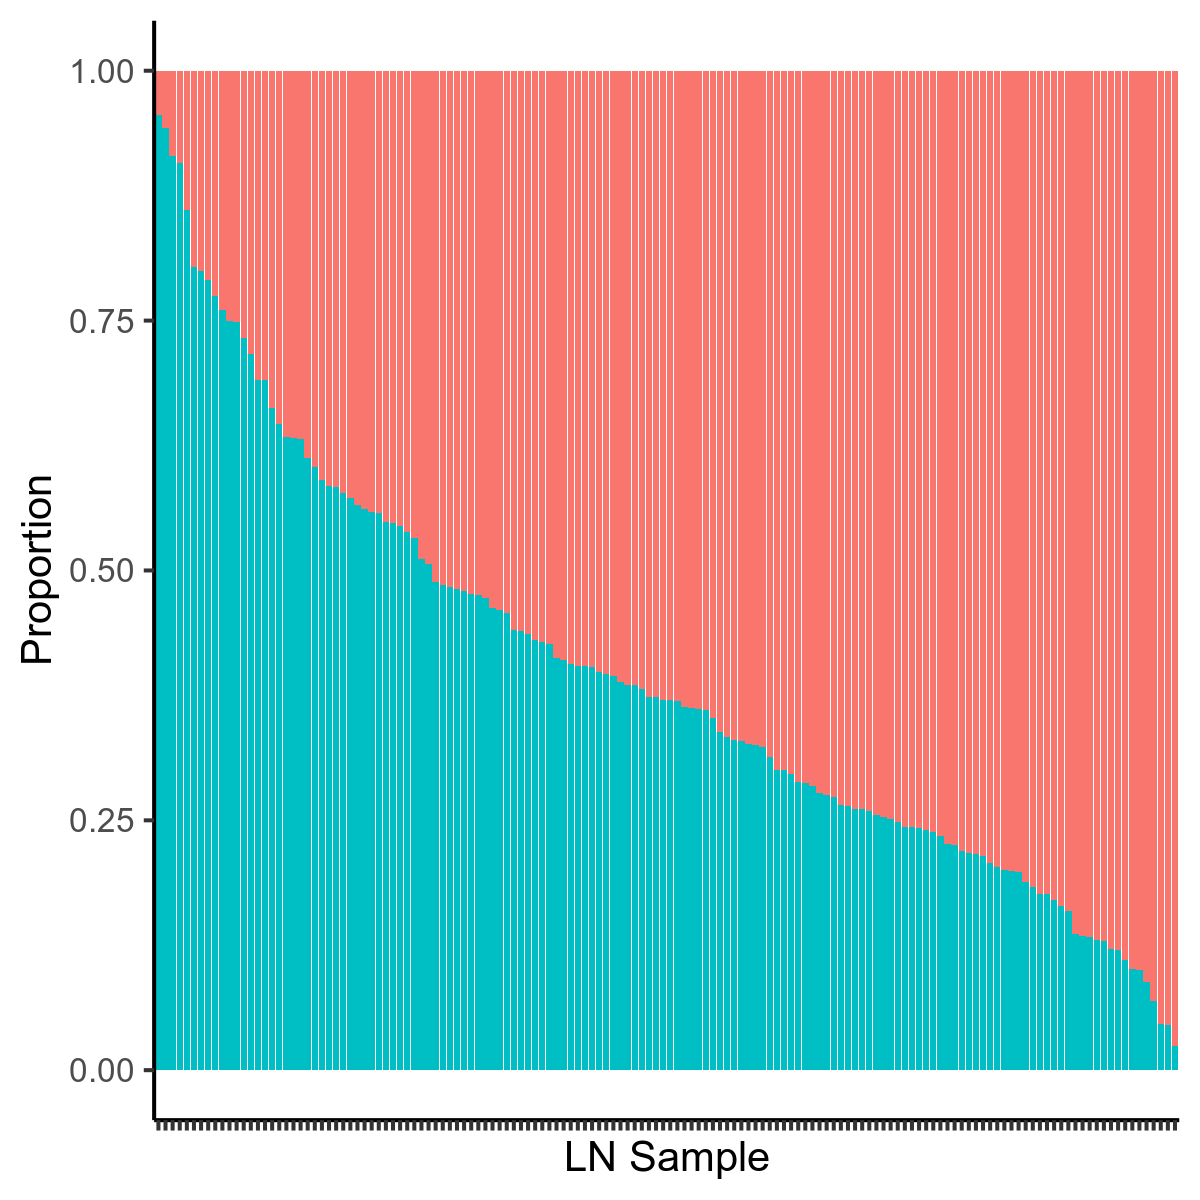

In [126]:
ggplot(lymph_myeloid %>% filter(individual %in% ind_keep), aes(x = individual, y = Freq, fill = immune_type)) + 
            geom_bar(stat = "identity", position = "stack") + 
            scale_x_discrete(limits = lymph_myeloid %>% 
                                            filter(individual %in% ind_keep,
                                                   immune_type == "Myeloid") %>% 
                                            arrange(desc(Freq)) %>% pull(individual)) + 
            theme_classic(base_size = 25) + 
            theme(axis.text.x = element_blank(),
                  legend.position = "none") + 
            labs(x = "LN Sample", y = "Proportion") 

In [129]:
lymph_myeloid <- lymph_myeloid %>% 
                    pivot_wider(names_from = "immune_type", values_from = "Freq") %>% 
                    left_join(clinical %>% select(individual, Final_Chronicity, Final_Activity, Final_ISN,
                                                  Responder.Status))

Joining, by = "individual"



	Pearson's product-moment correlation

data:  chron_df$Final_Chronicity and chron_df$Lymphoid
t = 3.764, df = 129, p-value = 0.0002528
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.151214 0.461219
sample estimates:
      cor 
0.3145802 


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 13 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”



	Pearson's product-moment correlation

data:  activity_df$Final_Activity and activity_df$Lymphoid
t = -1.8757, df = 129, p-value = 0.06295
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.325372819  0.008831297
sample estimates:
      cor 
-0.162941 


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 13 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”


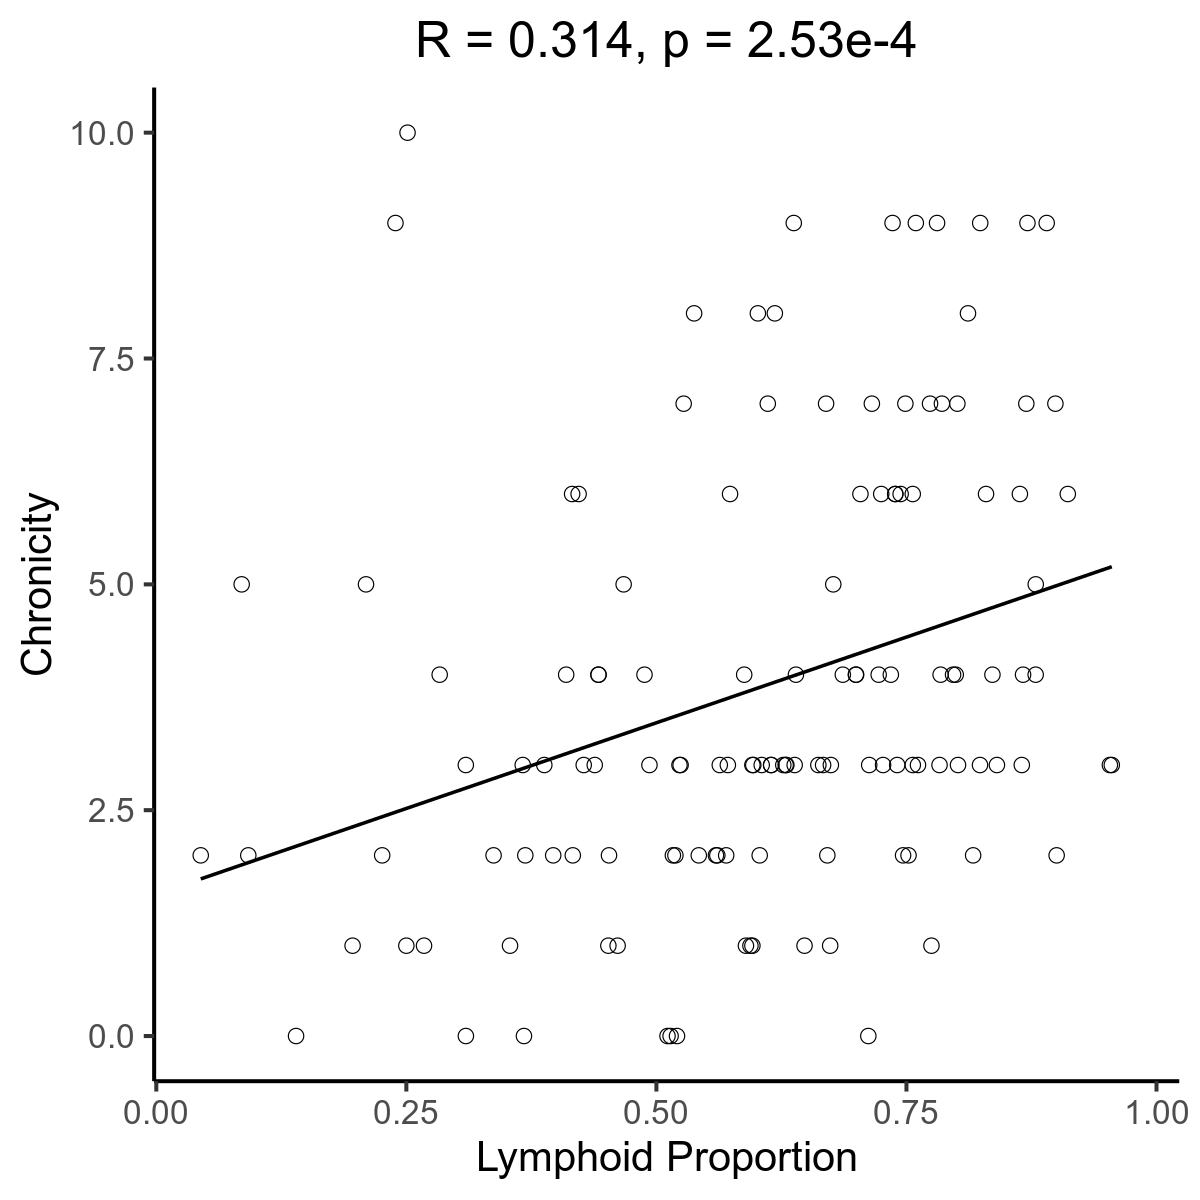

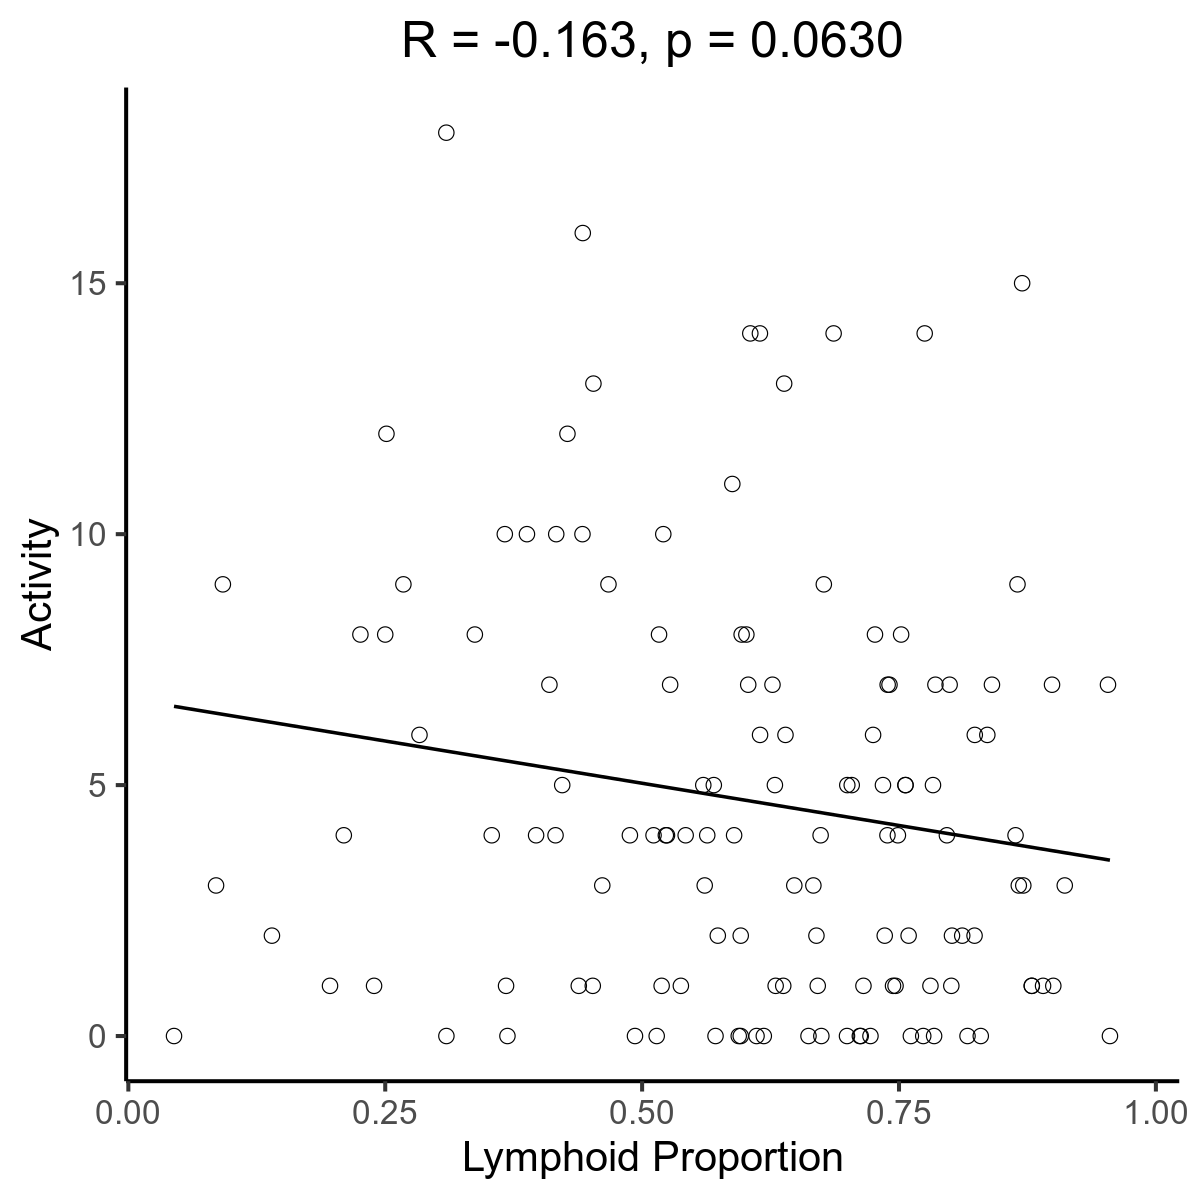

In [164]:
chron_df <- lymph_myeloid %>% 
                filter(individual %in% ind_keep) %>% 
                select(Final_Chronicity, Lymphoid) %>% na.omit()
cor.test(chron_df$Final_Chronicity, chron_df$Lymphoid)

ggplot(lymph_myeloid %>% filter(individual %in% ind_keep), 
           aes(x = Lymphoid, y = Final_Chronicity)) + 
    geom_point(shape = 1, size = 4) + 
    geom_smooth(method = "lm", se = FALSE, color = "black") + 
    theme_classic(base_size = 25) + 
    labs(x = "Lymphoid Proportion", y = "Chronicity",
         title = "R = 0.314, p = 2.53e-4") + 
    theme(plot.title = element_text(hjust = 0.5))



activity_df <- lymph_myeloid %>% 
                filter(individual %in% ind_keep) %>% 
                select(Final_Activity, Lymphoid) %>% na.omit()
cor.test(activity_df$Final_Activity, activity_df$Lymphoid)

ggplot(lymph_myeloid %>% filter(individual %in% ind_keep), 
           aes(x = Lymphoid, y = Final_Activity)) + 
    geom_point(shape = 1, size = 4) + 
    geom_smooth(method = "lm", se = FALSE, color = "black") + 
    theme_classic(base_size = 25) + 
    labs(x = "Lymphoid Proportion", y = "Activity",
         title = "R = -0.163, p = 0.0630") + 
    theme(plot.title = element_text(hjust = 0.5))


[1] FALSE


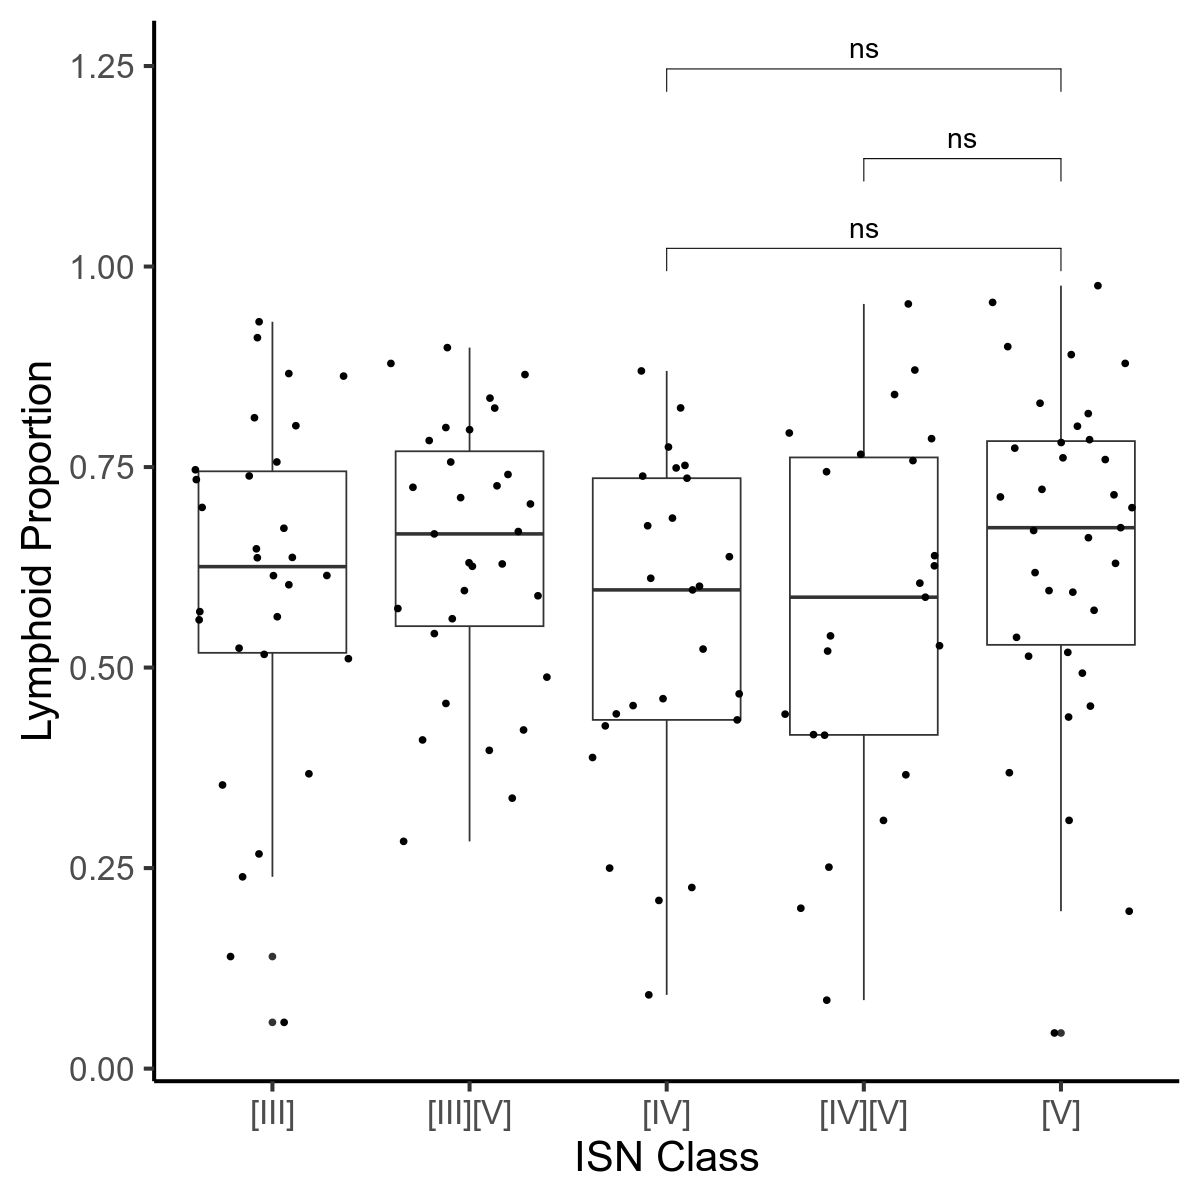

In [156]:
my_comparisons <- list(
                        c("[IV]", "[V]"),
                        c("[IV][V]", "[V]"),
                        c("[IV]", "[V]"))

ggplot(lymph_myeloid %>% filter(individual %in% ind_keep), aes(x = Final_ISN,
                                                               y = Lymphoid)) + 
    geom_boxplot() + 
    geom_jitter() + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Lymphoid Proportion") +
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

[1] FALSE


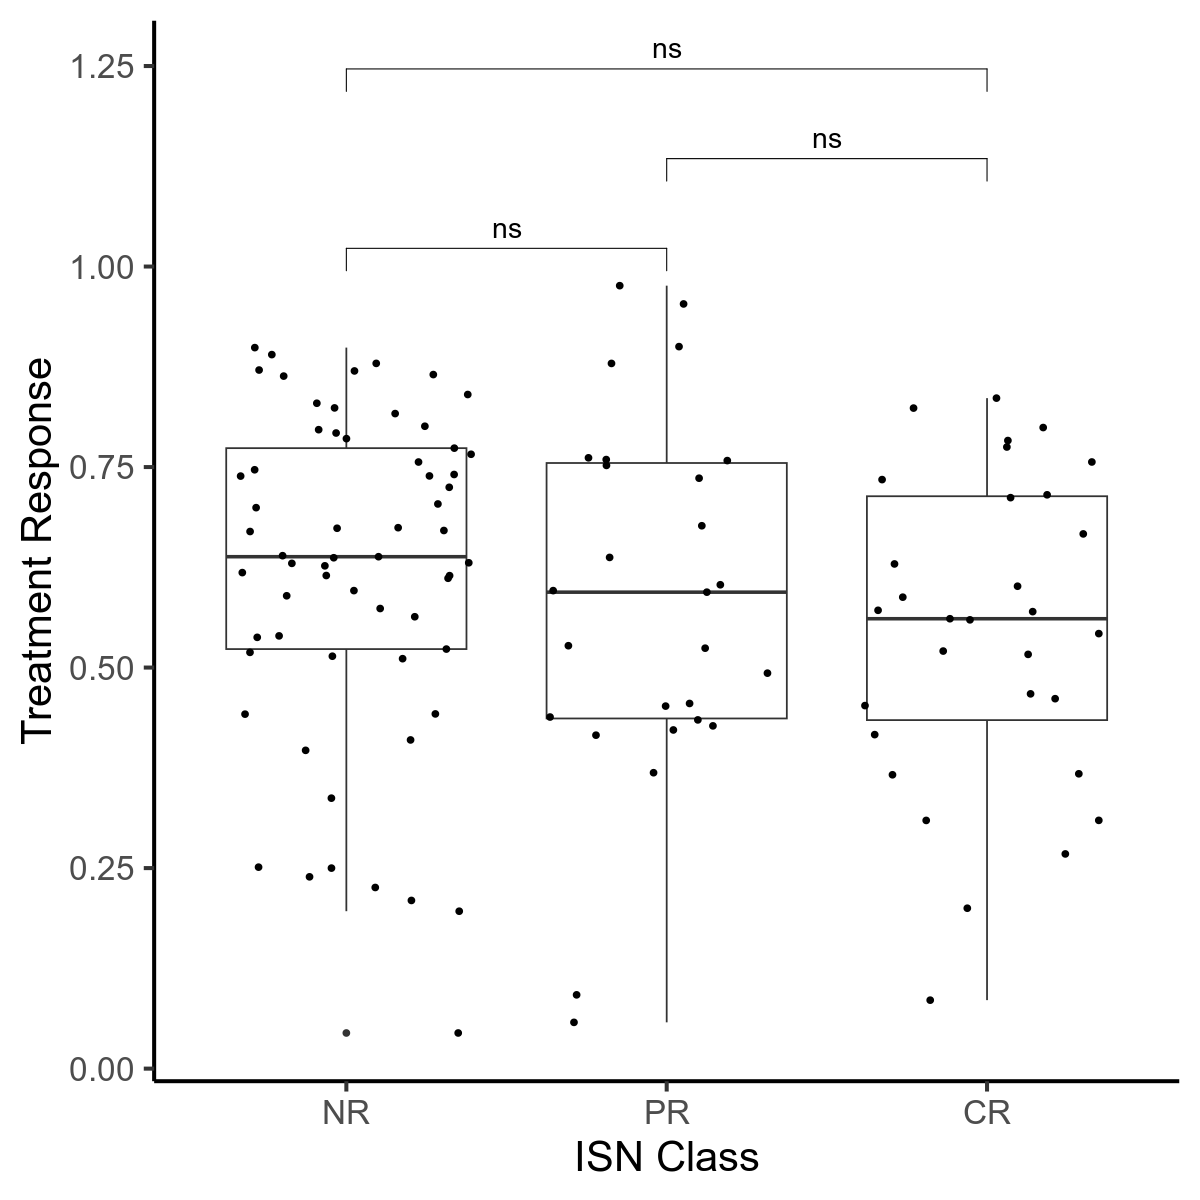

In [161]:
my_comparisons <- list(
                        c("NR", "PR"),
                        c("PR", "CR"),
                        c("NR", "CR"))

ggplot(lymph_myeloid %>% filter(individual %in% ind_keep,
                                Responder.Status %in% c("NR", "PR", "CR")), 
                                                              aes(x = Responder.Status,
                                                               y = Lymphoid)) + 
    geom_boxplot() + 
    geom_jitter() + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Treatment Response") +
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) + 
    scale_x_discrete(limits = c("NR", "PR", "CR"))

# Chronicity correlations

In [249]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% rename(Final_Site = Site)

In [15]:
clinical_LN <- clinical %>% filter(Type == "LN")

In [16]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

In [235]:
clinical_LN <- clinical_LN %>% 
                select(Final_Chronicity, 
                       Final_Activity,
                       Final_ISN,
                       Age,
                       Sex,
                       Final_Site,
                       Race,
                       individual, 
                       Responder.Status) %>% 
                left_join(first_biop_pred %>% select(Pred_use, First_biop, individual)) %>% 
                mutate(Responder.Status = ifelse(Responder.Status %in% c("NR", "PR", "CR"), Responder.Status, NA)) %>% 
                left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                     Responder_Status = c(0, 1, 2))) %>% 
                mutate(Sex = ifelse(Sex == "Female", 0, 1))

clinical_LN <- fastDummies::dummy_cols(clinical_LN, "Race")
clinical_LN <- fastDummies::dummy_cols(clinical_LN, "Final_ISN")
clinical_LN <- fastDummies::dummy_cols(clinical_LN, "Final_Site")


clinical_LN <- clinical_LN %>% select(-c(Responder.Status, individual, Final_ISN, Final_Site, Race))

Joining, by = "individual"
Joining, by = "Responder.Status"


In [236]:
cor_df <- data.frame()

In [263]:
for (i in colnames(clinical_LN)[2:ncol(clinical_LN)]) {
    df <- clinical_LN[, c("Final_Chronicity", i)] %>% na.omit()
    est <- cor.test(unlist(df[, "Final_Chronicity"]), unlist(df[, i]))$estimate ^ 2
    pval <- cor.test(unlist(df[, "Final_Chronicity"]), unlist(df[, i]))$p.value
    cor_df <- rbind(cor_df, 
                    data.frame("Final_Chronicity", i, est, pval))
}

Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”


In [262]:
model_df <- clinical_LN[, c(2, grep('ISN', colnames(clinical_LN)))] %>% na.omit()
colnames(model_df) <- c('Final_Activity', 'FinalISNIII', 'FinalISNIIIV',
                        'FinalISNIV', 'FinalISNIVV', 'FinalISNV')
summary(lm(Final_Activity ~ FinalISNIIIV + FinalISNIV + FinalISNIVV + FinalISNV, data = model_df))


Call:
lm(formula = Final_Activity ~ FinalISNIIIV + FinalISNIV + FinalISNIVV + 
    FinalISNV, data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1538 -1.1579 -0.1559  0.9063  9.9062 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.0938     0.5108   8.014 3.81e-13 ***
FinalISNIIIV   0.4580     0.7409   0.618    0.537    
FinalISNIV     4.0601     0.7630   5.321 3.96e-07 ***
FinalISNIVV    4.0641     0.8369   4.856 3.14e-06 ***
FinalISNV     -3.6937     0.6854  -5.390 2.89e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.89 on 141 degrees of freedom
Multiple R-squared:  0.5205,	Adjusted R-squared:  0.5069 
F-statistic: 38.27 on 4 and 141 DF,  p-value: < 2.2e-16


In [20]:
colnames(cor_df) <- c("Variable1", "Variable2", "correlation", "pvalue")

In [21]:
cor_df$FDR <- p.adjust(cor_df$pvalue)

In [22]:
plot_df <- cor_df %>% mutate(correlation = as.numeric(correlation),
                             pvalue = as.numeric(pvalue))
plot_df[! is.na(str_extract(plot_df[, 'Variable2'], 'Race')), 'Variable2'] <- na.omit(str_extract(plot_df[, 'Variable2'], 'Race'))
plot_df[! is.na(str_extract(plot_df[, 'Variable2'], 'ISN')), 'Variable2'] <- na.omit(str_extract(plot_df[, 'Variable2'], 'ISN'))
plot_df[! is.na(str_extract(plot_df[, 'Variable2'], 'Site')), 'Variable2'] <- na.omit(str_extract(plot_df[, 'Variable2'], 'Site'))
plot_df <- plot_df %>% na.omit() %>% group_by(Variable1, Variable2) %>% filter(correlation == max(correlation))
plot_df$bfpval <- p.adjust(plot_df$pvalue, method = "bonferroni")

Warning message in geom_text(aes(label = label), size = 15, face = "bold"):
“Ignoring unknown parameters: `face`”
Warning message:
“Removed 8 rows containing missing values (`geom_text()`).”


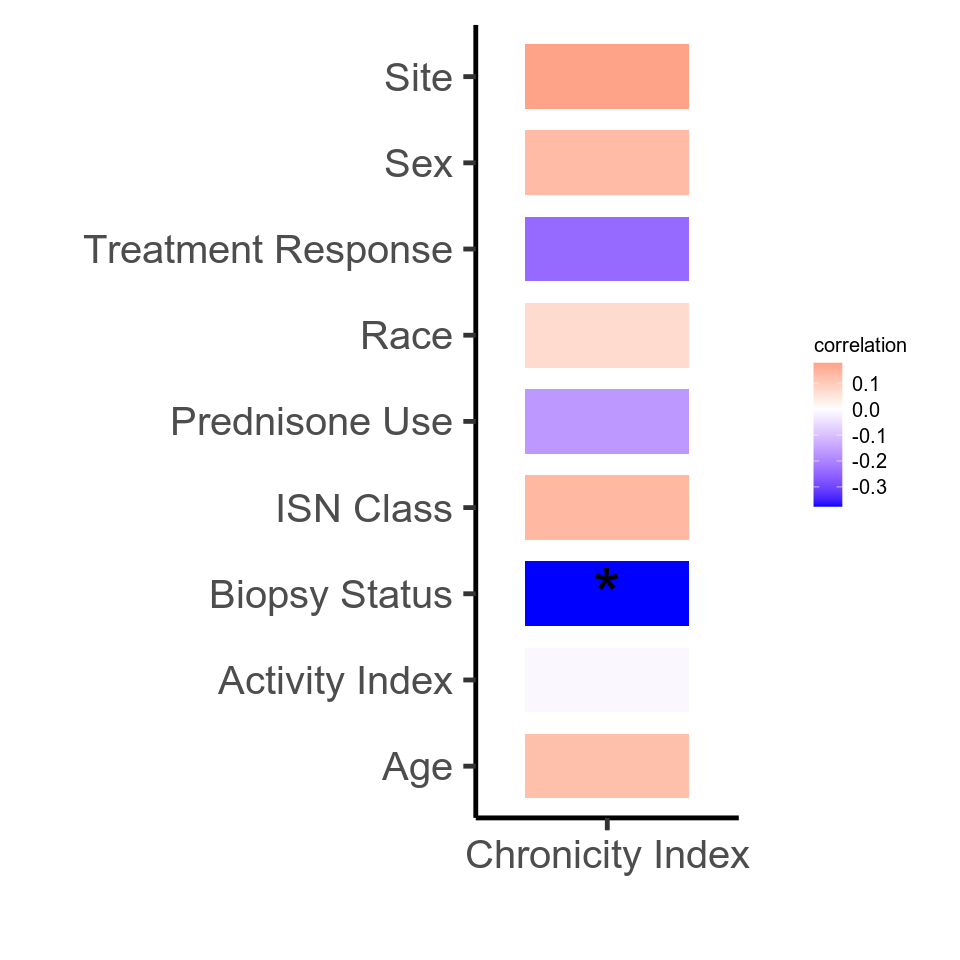

In [ ]:
fig.size(8, 8)
ggplot(data = plot_df %>% mutate(label = ifelse(bfpval < 0.05, '*', NA)),
               aes(x = Variable1, y = Variable2, fill = as.numeric(correlation))) + 
    geom_tile(width = 0.75, height = 0.75) +
    geom_text(aes(label = label), size = 15, face = "bold") + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high = "red") + 
    theme_classic(base_size = 30) + 
    labs(x = "", y = "", fill = "correlation") + 
    theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 12)) + 
    scale_x_discrete(labels = c("Chronicity Index")) + 
    scale_y_discrete(labels = c("Age",
                                "Activity Index",
                                "Biopsy Status",
                                "ISN Class", 
                                "Prednisone Use",
                                "Race", 
                                "Treatment Response", 
                                "Sex", 
                                "Site"))

In [27]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% rename(Final_Site = Site)

[1] FALSE


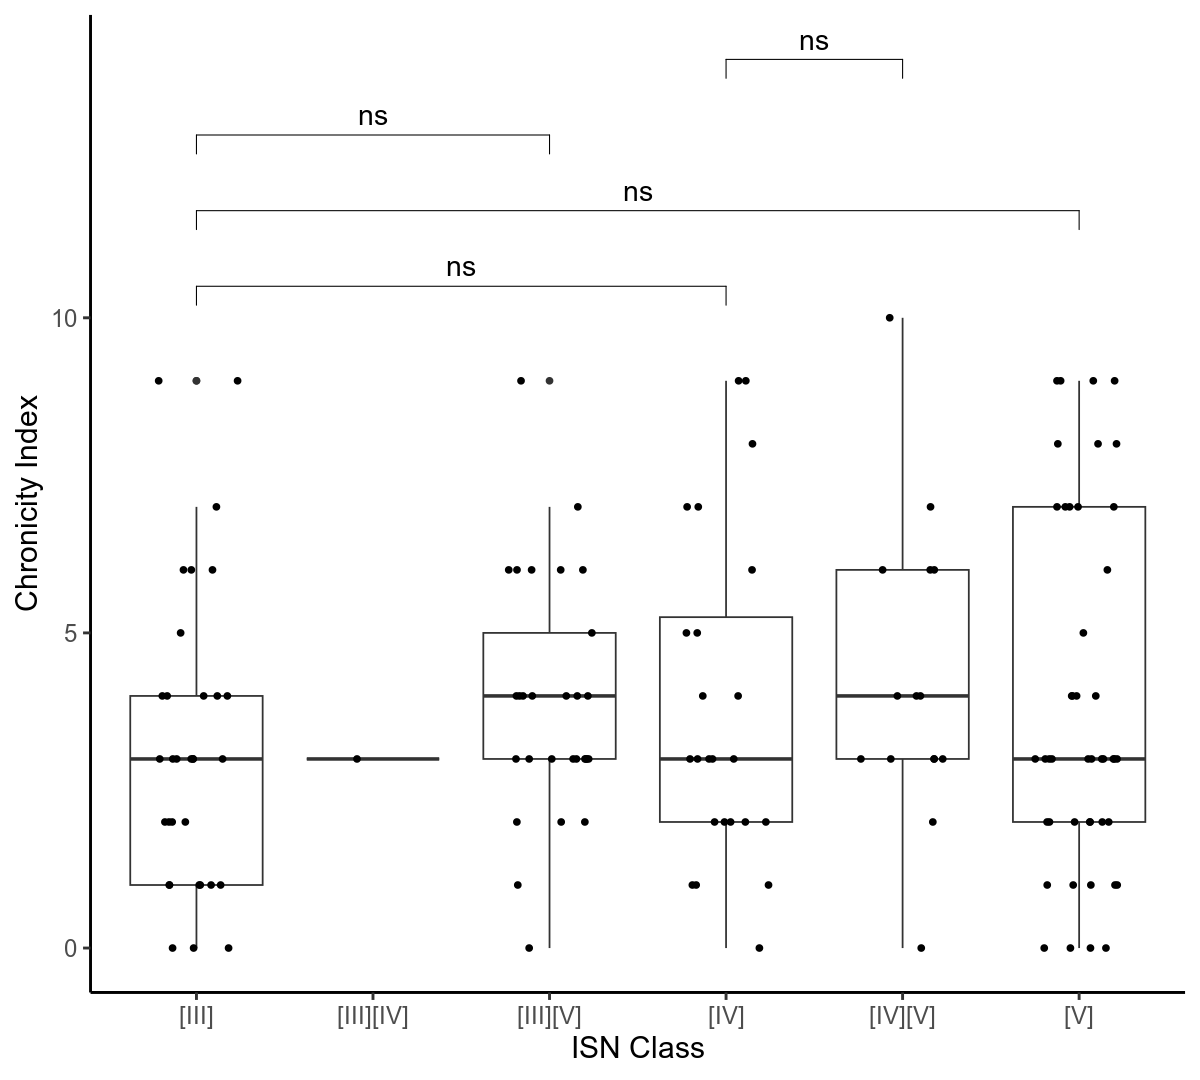

In [36]:
my_comparisons <- list(c("[III]", "[IV]"),
                       c("[III]", "[V]"),
                       c("[III]", "[III][V]"),
                       c("[IV]", "[IV][V]"))
ggplot(clinical %>% 
           select(ISN, Final_Chronicity) %>% 
           na.omit(), aes(x = factor(ISN), y = Final_Chronicity)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 18) + 
    labs(x = "ISN Class", y = "Chronicity Index") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

[1] FALSE
[1] FALSE


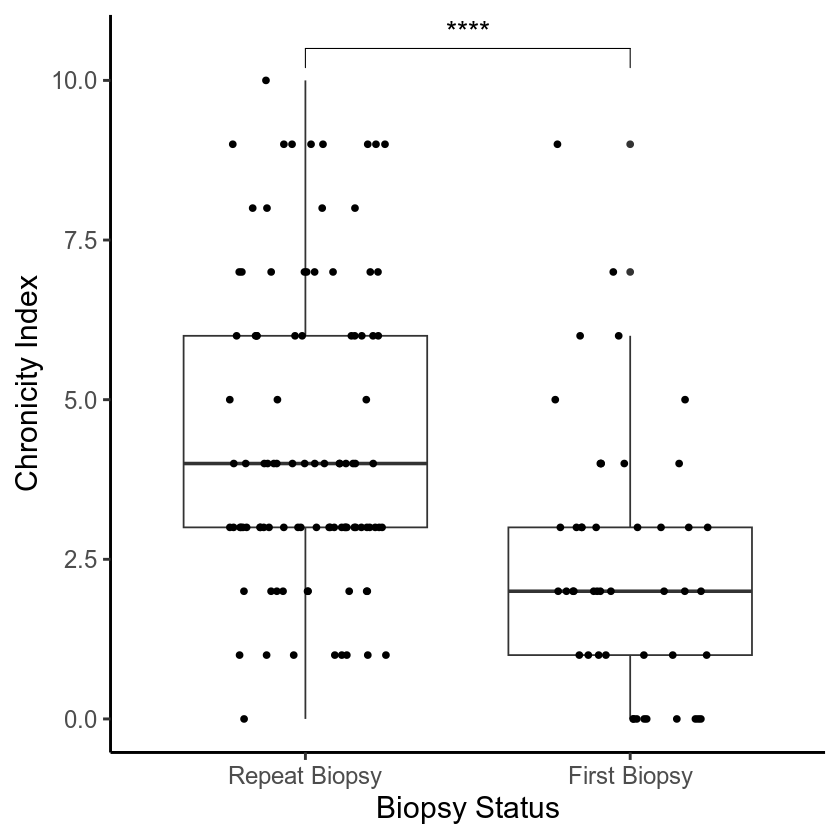

[1] FALSE


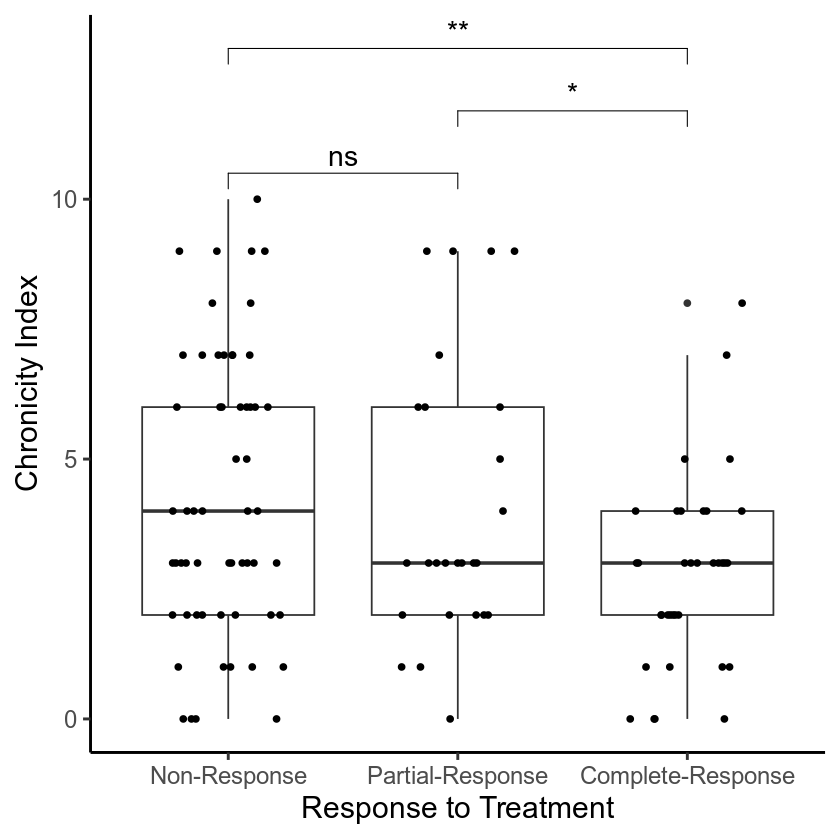

[1] FALSE


Warning message:
“Computation failed in `stat_signif()`
Caused by error in `t.test.default()`:
! not enough 'y' observations”


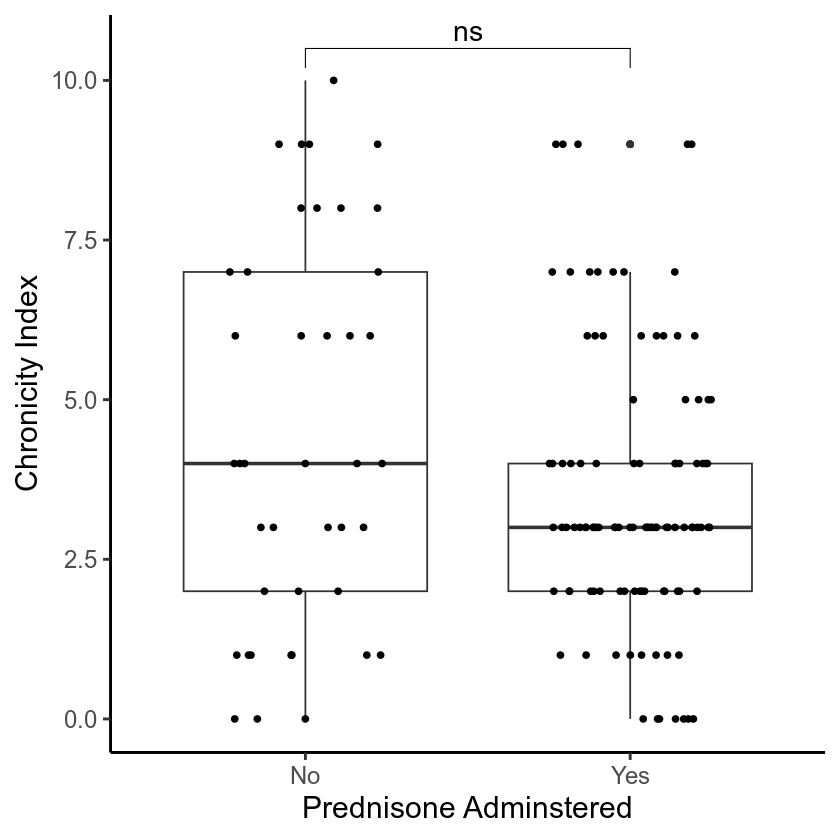

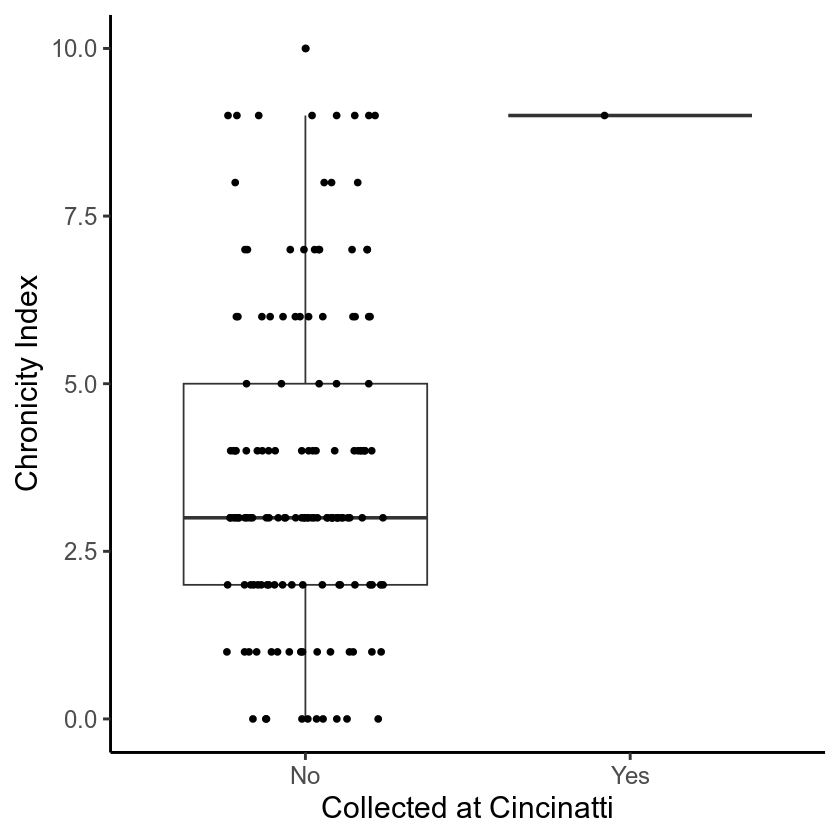

In [351]:

ggplot(clinical_LN %>% 
           select(Final_ISN, Final_Chronicity) %>% 
           na.omit(), aes(x = factor(Final_ISN), y = Final_Chronicity)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 18) + 
    scale_x_discrete(labels = c("Repeat Biopsy", "First Biopsy")) + 
    labs(x = "Biopsy Status", y = "Chronicity Index") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

my_comparisons <- list(c("0", "1"),
                       c("1", "2"),
                       c("0", "2"))

my_comparisons <- list(c("0", "1"))

ggplot(clinical_LN %>% 
           select(First_biop, Final_Chronicity) %>% 
           na.omit(), aes(x = factor(First_biop), y = Final_Chronicity)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 18) + 
    scale_x_discrete(labels = c("Repeat Biopsy", "First Biopsy")) + 
    labs(x = "Biopsy Status", y = "Chronicity Index") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

my_comparisons <- list(c("0", "1"),
                       c("1", "2"),
                       c("0", "2"))

ggplot(clinical_LN %>% 
           select(Final_Chronicity, Responder_Status) %>% 
           na.omit(), aes(x = factor(Responder_Status), y = Final_Chronicity)) + 
    geom_boxplot() + 
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 18) + 
    scale_x_discrete(labels = c("Non-Response", "Partial-Response", "Complete-Response")) + 
    labs(x = "Response to Treatment", y = "Chronicity Index") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)


my_comparisons <- list(c("0", "1"))

ggplot(clinical_LN %>% 
           select(Final_Chronicity, Pred_use) %>% 
           na.omit(), aes(x = factor(Pred_use), y = Final_Chronicity)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 18) + 
    scale_x_discrete(labels = c("No", "Yes")) + 
    labs(x = "Prednisone Adminstered", y = "Chronicity Index") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)


my_comparisons <- list(c("0", "1"))

ggplot(clinical_LN %>% 
           select(Final_Chronicity, Final_Site_Cincinnati) %>% 
           na.omit(), aes(x = factor(Final_Site_Cincinnati), y = Final_Chronicity)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 18) + 
    scale_x_discrete(labels = c("No", "Yes")) + 
    labs(x = "Collected at Cincinatti", y = "Chronicity Index") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

# Activity Correlations

In [34]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% rename(Final_Site = Site)

In [35]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

In [36]:
clinical_LN <- clinical %>% filter(Type == "LN")
clinical_LN <- clinical_LN %>% 
                select(Final_Chronicity, 
                       Final_Activity,
                       Final_ISN,
                       Age,
                       Sex,
                       Final_Site,
                       Race,
                       individual, 
                       Responder.Status) %>% 
                left_join(first_biop_pred %>% select(Pred_use, First_biop, individual)) %>% 
                mutate(Responder.Status = ifelse(Responder.Status %in% c("NR", "PR", "CR"), Responder.Status, NA)) %>% 
                left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                     Responder_Status = c(0, 1, 2))) %>% 
                mutate(Sex = ifelse(Sex == "Female", 0, 1))
clinical_LN <- fastDummies::dummy_cols(clinical_LN, 'Race')
clinical_LN <- fastDummies::dummy_cols(clinical_LN, 'Final_Site')
clinical_LN <- fastDummies::dummy_cols(clinical_LN, 'Final_ISN')
clinical_LN <- clinical_LN %>% select(-Responder.Status)

Joining, by = "individual"
Joining, by = "Responder.Status"


In [37]:
num_columns <- c('Final_Chronicity', 'Pred_use', 'First_biop',
                 'Age', 'Sex', 'Responder_Status')
cor_df <- data.frame()
for (i in num_columns) {
    df <- clinical_LN[, c("Final_Activity", i)] %>% na.omit()
    est <- cor.test(unlist(df[, "Final_Activity"]), unlist(df[, i]))$estimate ^ 2
    pval <- cor.test(unlist(df[, "Final_Activity"]), unlist(df[, i]))$p.value
    cor_df <- rbind(cor_df, 
                    data.frame("Final_Activity", i, est, pval))
}

In [38]:
model_df <- clinical_LN[, c(2, grep('Race', colnames(clinical_LN)))] %>% na.omit()
colnames(model_df) <- c('Final_Activity', 'Race', 'RaceA', 'RaceAB',
                        'RaceB', 'RaceBAI','RaceBW', 'RaceU', 'RaceW')
summary(lm(Final_Activity ~ RaceAB + RaceB + RaceBAI + RaceBW + RaceU + RaceW, data = model_df))
cor_df <- cor_df %>% rbind(c("Final_Activity", 'Race', 0.04397, 0.05568))


Call:
lm(formula = Final_Activity ~ RaceAB + RaceB + RaceBAI + RaceBW + 
    RaceU + RaceW, data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.3182 -3.2664 -0.6812  2.2114 14.3188 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.1111     0.9484   5.389 2.95e-07 ***
RaceAB        1.8889     4.1341   0.457   0.6485    
RaceB        -1.4300     1.0650  -1.343   0.1816    
RaceBAI      -5.1111     4.1341  -1.236   0.2184    
RaceBW        8.8889     4.1341   2.150   0.0333 *  
RaceU        -1.3611     1.4996  -0.908   0.3656    
RaceW         0.2071     1.1258   0.184   0.8543    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.024 on 139 degrees of freedom
Multiple R-squared:  0.08353,	Adjusted R-squared:  0.04397 
F-statistic: 2.111 on 6 and 139 DF,  p-value: 0.05568


In [39]:
model_df <- clinical_LN[, c(2, grep('ISN', colnames(clinical_LN)))] %>% na.omit()
colnames(model_df) <- c('Final_Activity', 'FinalISN', 'FinalISNIII', 'FinalISNIIIV',
                        'FinalISNIV', 'FinalISNIVV', 'FinalISNV')
summary(lm(Final_Activity ~ FinalISNIIIV + FinalISNIV + FinalISNIVV + FinalISNV, data = model_df))
cor_df <- cor_df %>% rbind(c("Final_Activity", 'ISN', 0.5069, 2.2e-16))


Call:
lm(formula = Final_Activity ~ FinalISNIIIV + FinalISNIV + FinalISNIVV + 
    FinalISNV, data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1538 -1.1579 -0.1559  0.9063  9.9062 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.0938     0.5108   8.014 3.81e-13 ***
FinalISNIIIV   0.4580     0.7409   0.618    0.537    
FinalISNIV     4.0601     0.7630   5.321 3.96e-07 ***
FinalISNIVV    4.0641     0.8369   4.856 3.14e-06 ***
FinalISNV     -3.6937     0.6854  -5.390 2.89e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.89 on 141 degrees of freedom
Multiple R-squared:  0.5205,	Adjusted R-squared:  0.5069 
F-statistic: 38.27 on 4 and 141 DF,  p-value: < 2.2e-16


In [40]:
model_df <- clinical_LN[, c(2, grep('Site', colnames(clinical_LN)))] %>% na.omit()
colnames(model_df) <- str_remove_all(colnames(model_df), "_")
colnames(model_df) <- str_remove_all(colnames(model_df), "-")
colnames(model_df) <- str_remove_all(colnames(model_df), " ")
summary(lm(FinalActivity ~ FinalSiteCedarsSinai + FinalSiteCincinnati + 
                           FinalSiteEinstein + FinalSiteJHU + 
                           FinalSiteMichigan + FinalSiteMUSC + 
                           FinalSiteNorthwell + FinalSiteNYU + 
                           FinalSiteRochester + FinalSiteTexasTech + 
                           FinalSiteUCLA + FinalSiteUCSD, data = model_df))
cor_df <- cor_df %>% rbind(c("Final_Activity", 'Site', 0.0547, 0.06654))


Call:
lm(formula = FinalActivity ~ FinalSiteCedarsSinai + FinalSiteCincinnati + 
    FinalSiteEinstein + FinalSiteJHU + FinalSiteMichigan + FinalSiteMUSC + 
    FinalSiteNorthwell + FinalSiteNYU + FinalSiteRochester + 
    FinalSiteTexasTech + FinalSiteUCLA + FinalSiteUCSD, data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9434 -3.0435 -0.4167  1.9891 12.0566 

Coefficients: (1 not defined because of singularities)
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            6.0000     1.6335   3.673 0.000345 ***
FinalSiteCedarsSinai       NA         NA      NA       NA    
FinalSiteCincinnati   -5.0000     4.3217  -1.157 0.249352    
FinalSiteEinstein     -2.6667     2.0006  -1.333 0.184808    
FinalSiteJHU          -2.9565     1.7367  -1.702 0.091007 .  
FinalSiteMichigan      2.0000     4.3217   0.463 0.644274    
FinalSiteMUSC         -1.4444     2.1088  -0.685 0.494548    
FinalSiteNorthwell    -6.0000     4.3217  -1.388 0.167338    

In [41]:
colnames(cor_df) <- c("Variable1", "Variable2", "correlation", "pvalue")
cor_df$bfpval <- p.adjust(cor_df$pvalue, method = 'bonferroni')

In [43]:
cor_df

,Variable1,Variable2,correlation,pvalue,bfpval
,<chr>,<chr>,<chr>,<chr>,<dbl>
cor,Final_Activity,Final_Chronicity,0.000170125984841499,0.875832832227901,1.000000e+00
cor1,Final_Activity,Pred_use,0.0785377406899228,0.000612462957942159,5.512167e-03
cor2,Final_Activity,First_biop,0.0046326923553522,0.414330232626636,1.000000e+00
cor3,Final_Activity,Age,0.012664686311502,0.176244908963079,1.000000e+00
cor4,Final_Activity,Sex,0.0220819627004778,0.0734443995012983,6.609996e-01
cor5,Final_Activity,Responder_Status,0.0152841073350024,0.180394311222324,1.000000e+00
7,Final_Activity,Race,0.04397,0.05568,5.011200e-01
8,Final_Activity,ISN,0.5069,2.2e-16,1.980000e-15
9,Final_Activity,Site,0.0547,0.06654,5.988600e-01


Warning message in geom_text(aes(label = label), size = 15, face = "bold"):
“Ignoring unknown parameters: `face`”
Warning message:
“Removed 7 rows containing missing values (`geom_text()`).”


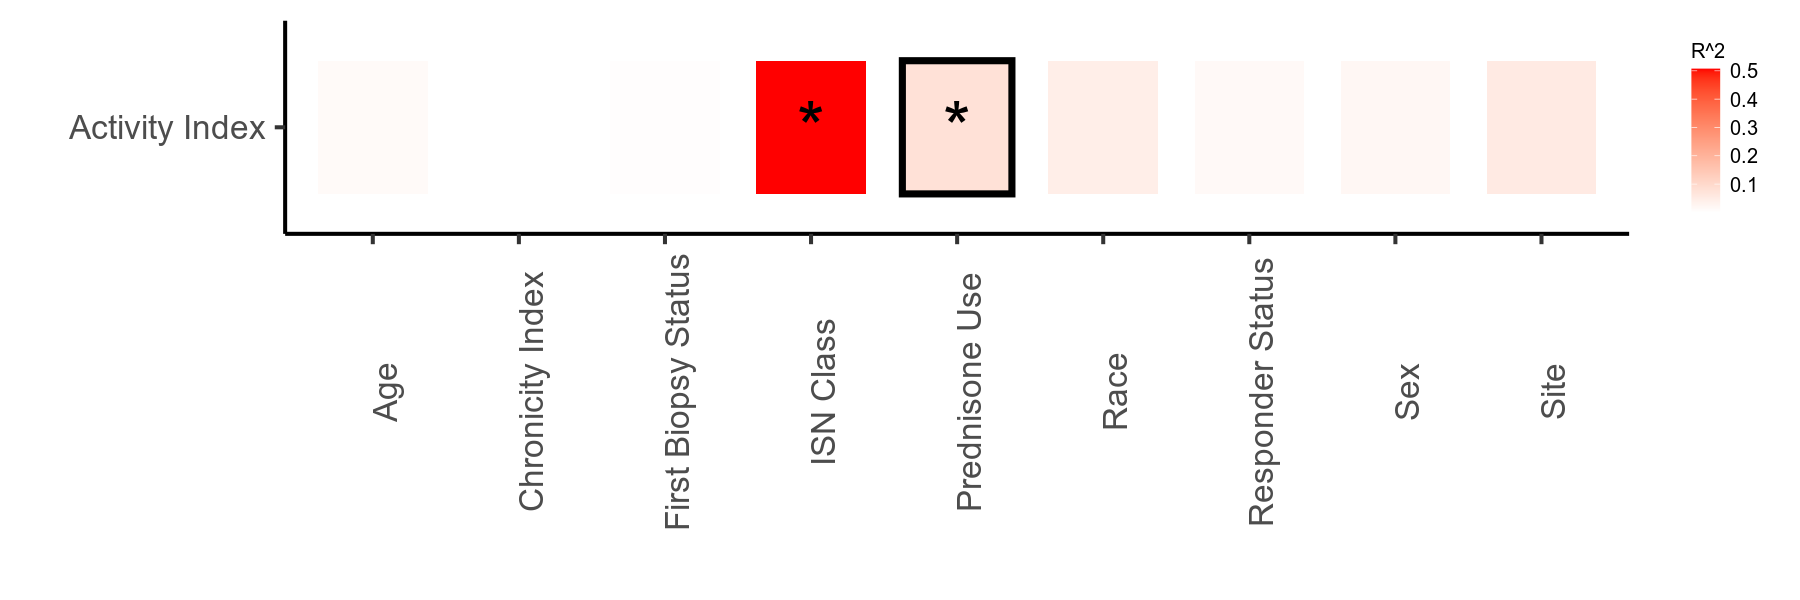

In [48]:
fig.size(5, 15)
ggplot(data = cor_df %>% mutate(label = ifelse(bfpval < 0.05, '*', NA)),
               aes(y = Variable1, x = Variable2, fill = as.numeric(correlation))) + 
    geom_tile(width = 0.75, height = 0.75) +
    geom_tile(data = cor_df %>% filter(pvalue < 0.05),
              color = "black", 
              width = 0.75, 
              height = 0.75,
              linewidth = 2) +
    geom_text(aes(label = label), size = 15, face = "bold") +  
    scale_fill_gradient2(low = "white",
                         high = "red") + 
    theme_classic(base_size = 25) + 
    labs(x = "", y = "", fill = "R^2") + 
    theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 12),
          axis.text.x = element_text(angle = 90)) + 
    scale_y_discrete(labels = c("Activity Index")) + 
    scale_x_discrete(labels = c("Age", 'Chronicity Index',
                                'First Biopsy Status', 'ISN Class',
                                'Prednisone Use', 'Race',
                                'Responder Status', 
                                'Sex', 'Site'))

[1] FALSE


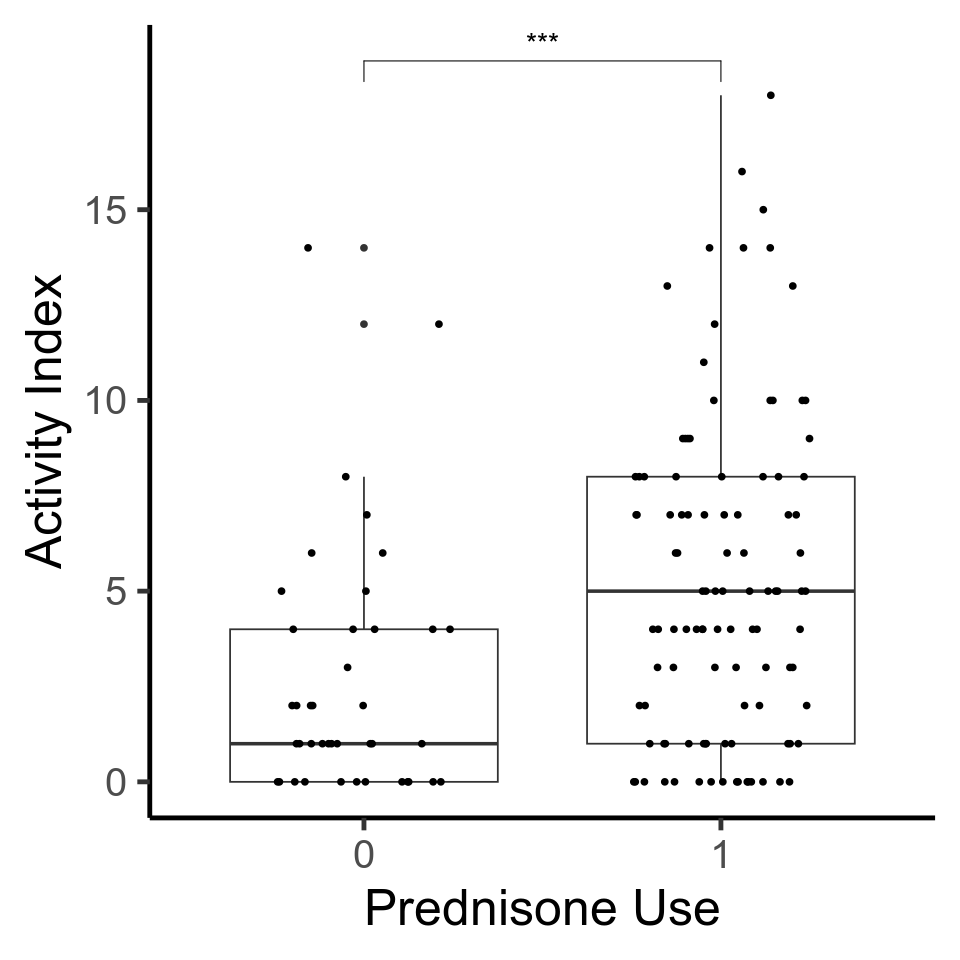

In [99]:
fig.size(8, 8)
my_comparisons <- list(c("0", "1"))

ggplot(clinical_LN %>% 
           select(Pred_use, Final_Activity) %>% 
           na.omit(), aes(x = factor(Pred_use), y = Final_Activity)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 30) + 
    labs(x = "Prednisone Use", y = "Activity Index") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

[1] FALSE


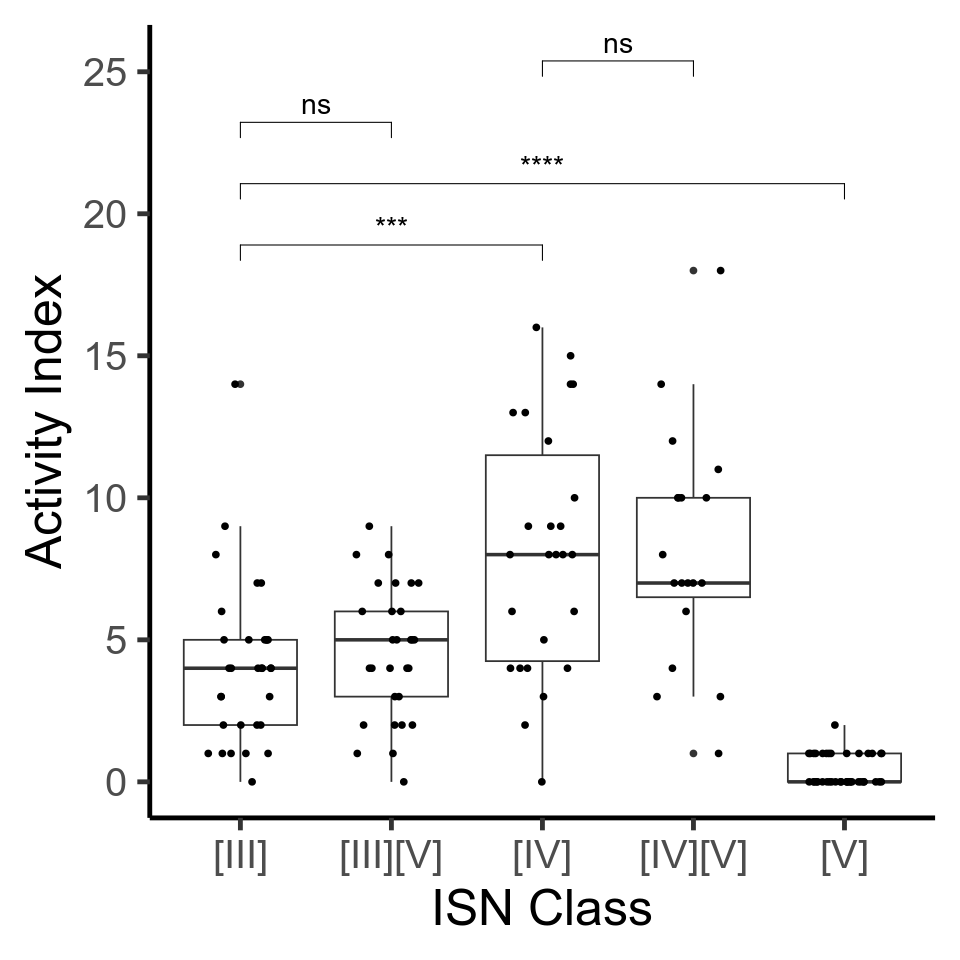

In [100]:
fig.size(8, 8)
my_comparisons <- list(c("[III]", "[IV]"),
                       c("[III]", "[V]"),
                       c("[III]", "[III][V]"),
                       c("[IV]", "[IV][V]"))
ggplot(clinical %>% 
           select(Final_ISN, Final_Activity) %>% 
           na.omit(), aes(x = factor(Final_ISN), y = Final_Activity)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 30) + 
    labs(x = "ISN Class", y = "Activity Index") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

In [356]:
clinical_LN <- clinical_LN %>% 
                    select(-Renamed_Site) %>% left_join(clinical_LN %>% 
                                            select(Final_Site) %>% 
                                            table() %>% data.frame() %>% 
                                            rename('Site' = '.') %>% 
                                            mutate(Final_Site = as.character(Site), 
                                                   Renamed_Site = ifelse(Freq < 20, "Other", Final_Site)))

Joining, by = c("Final_Site", "Site", "Freq")


[1] FALSE


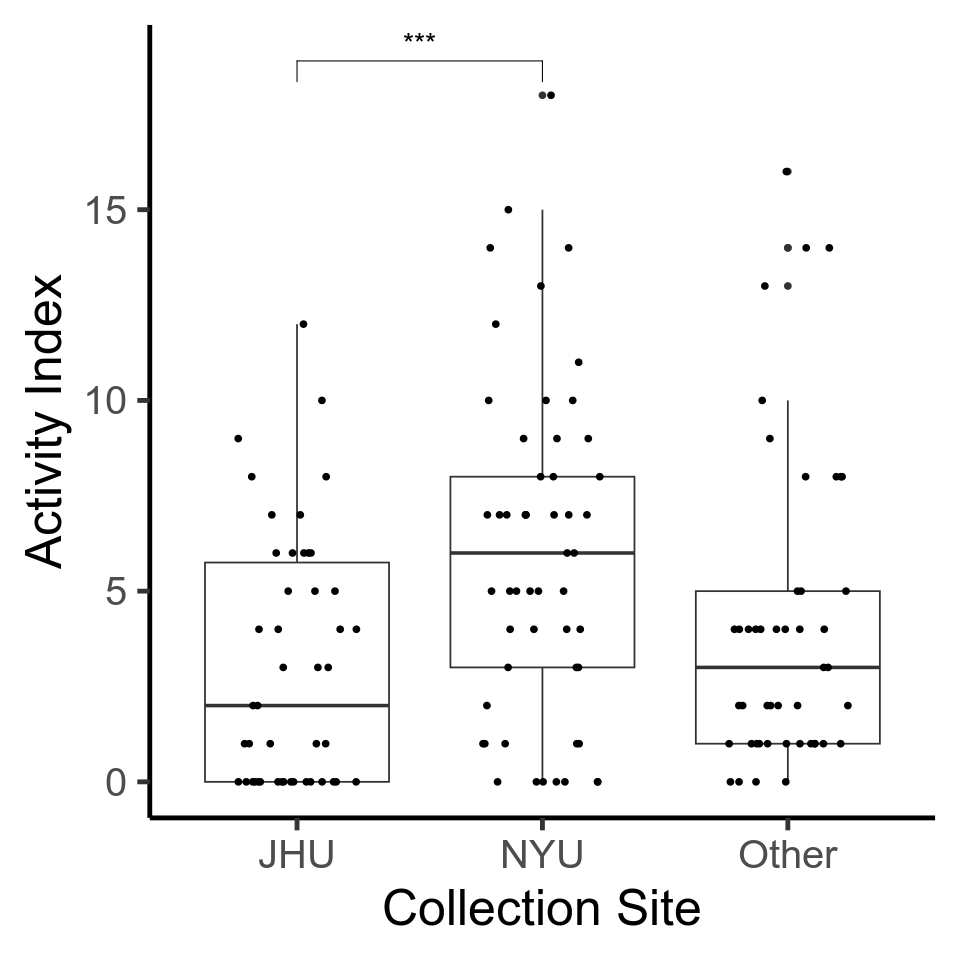

In [358]:
fig.size(8, 8)

my_comparisons <- list(c("NYU", "JHU"))


ggplot(clinical_LN %>% 
           select(Final_Activity, Renamed_Site) %>% 
           na.omit(), aes(x = factor(Renamed_Site), y = Final_Activity)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 30) + 
    labs(x = "Collection Site", y = "Activity Index") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

In [161]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/Myeloid_clusterQCd_meta_harmonizedPCUMAPCellStateClusters_10042022.rds')
freq_table <- qcd_meta %>% 
                group_by(new_cluster_number) %>% 
                select(sample, new_cluster_number) %>% 
                table() %>% data.frame() %>% 
                pivot_wider(values_from = "Freq", names_from = 'new_cluster_number')
prop_table <- data.frame(sample = freq_table$sample, 
                         M0_Freq =  freq_table[, "0"] / rowSums(freq_table[, -1]),
                         M5_Freq = freq_table[, "5"] / rowSums(freq_table[, -1]),
                         M11_Freq = freq_table[, "11"] / rowSums(freq_table[, -1]))
prop_table <- prop_table[grep("cells", prop_table$sample), ]
prop_table <- prop_table %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3])
prop_table <- prop_table %>% 
                rename(M0_Freq = X0,
                       M5_Freq = X5,
                       M11_Freq = X11)

In [373]:
colnames(clinical_LN) <- str_remove_all(str_remove_all(colnames(clinical_LN), "\\["), "\\]")
activity_df <- prop_table %>% 
            left_join(clinical_LN %>% 
                        select(individual, Final_ISN_IV, Final_ISN_IVV, 
                               Final_ISN_V, Pred_use, 
                               Final_Site_JHU, Final_Site_NYU, 
                               Final_Activity), by = 'individual') %>% 
            na.omit()
activity_df$Residualized_Activity <- lm(Final_Activity ~ Final_ISN_IV + Final_ISN_IVV + 
                                                         Final_ISN_V + Pred_use + 
                                                         Final_Site_JHU + Final_Site_NYU,
                                        activity_df)$resid

In [389]:
cor.test(activity_df$M5_Freq, activity_df$Final_Activity)
cor.test(activity_df$M5_Freq, activity_df$Residualized_Activity)


	Pearson's product-moment correlation

data:  activity_df$M5_Freq and activity_df$Final_Activity
t = 6.0084, df = 139, p-value = 1.558e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3121807 0.5761271
sample estimates:
    cor 
0.45406 



	Pearson's product-moment correlation

data:  activity_df$M5_Freq and activity_df$Residualized_Activity
t = 3.3169, df = 139, p-value = 0.001162
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1104518 0.4174424
sample estimates:
      cor 
0.2708191 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


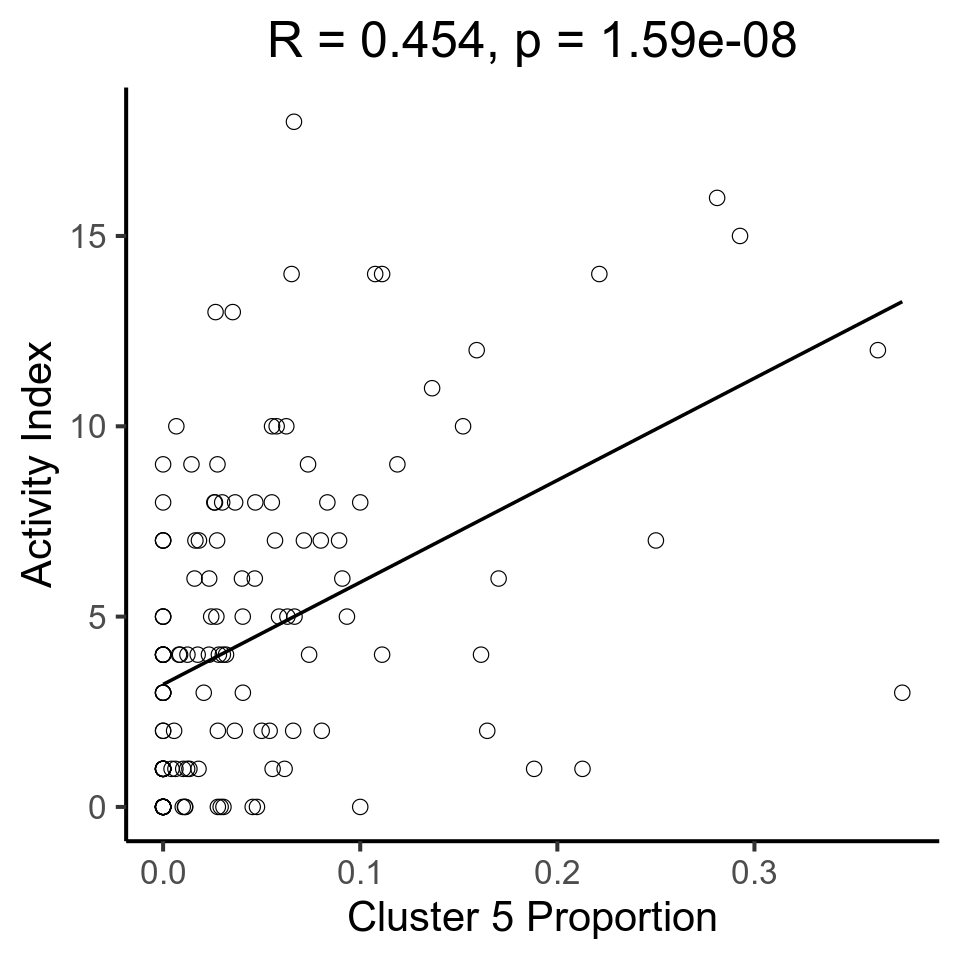

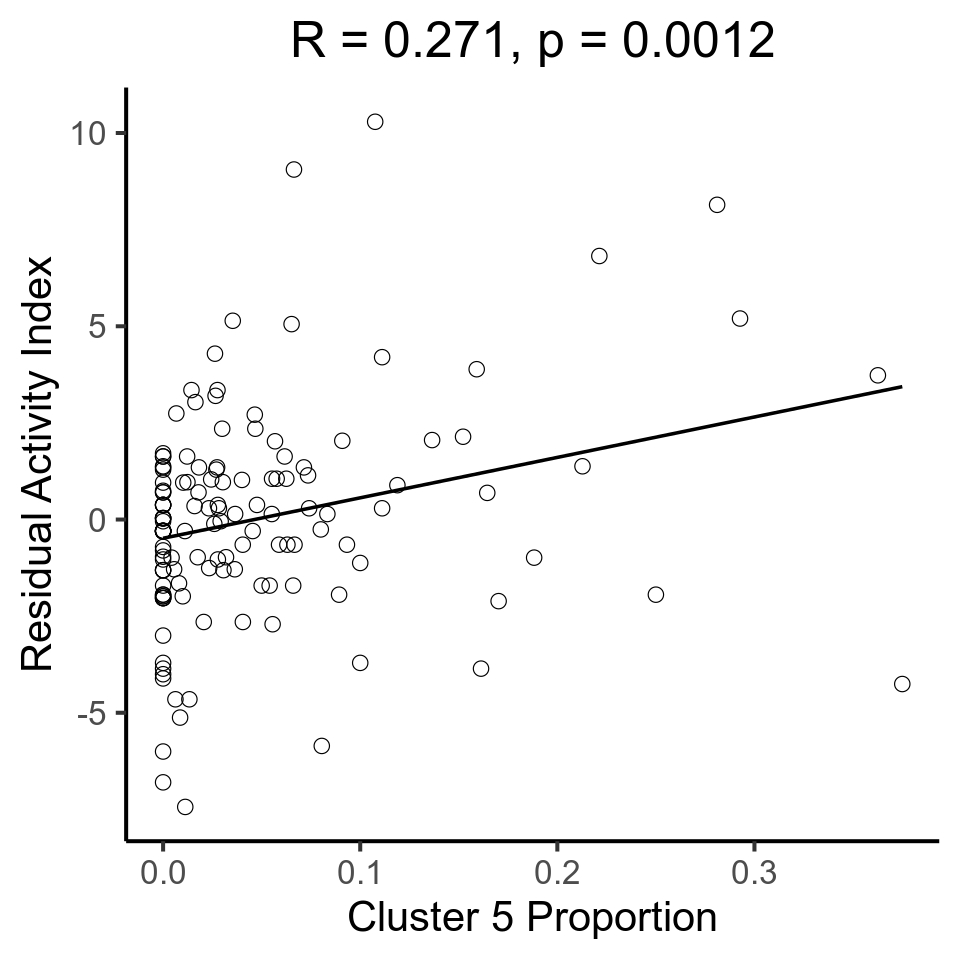

In [390]:
fig.size(8, 8)
ggplot(activity_df, 
           aes(x = M5_Freq, y = Final_Activity)) + 
    geom_point(shape = 1, size = 4) + 
    geom_smooth(method = "lm", se = FALSE, color = "black") + 
    theme_classic(base_size = 25) + 
    labs(x = "Cluster 5 Proportion", 
         y = "Activity Index",
         title = "R = 0.454, p = 1.59e-08") + 
    theme(plot.title = element_text(hjust = 0.5))
ggplot(activity_df, 
           aes(x = M5_Freq, y = Residualized_Activity)) + 
    geom_point(shape = 1, size = 4) + 
    geom_smooth(method = "lm", se = FALSE, color = "black") + 
    theme_classic(base_size = 25) + 
    labs(x = "Cluster 5 Proportion", 
         y = "Residual Activity Index",
         title = "R = 0.271, p = 0.0012") + 
    theme(plot.title = element_text(hjust = 0.5))

[1] FALSE
[1] FALSE


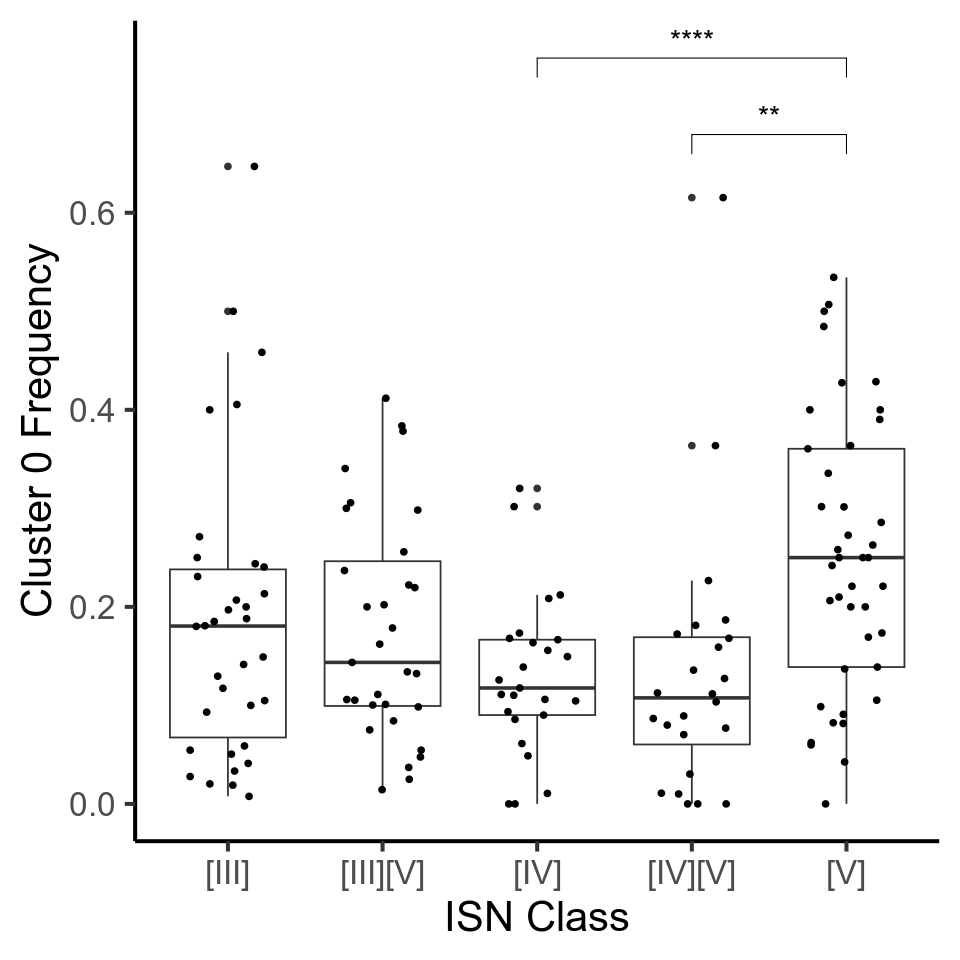

[1] FALSE


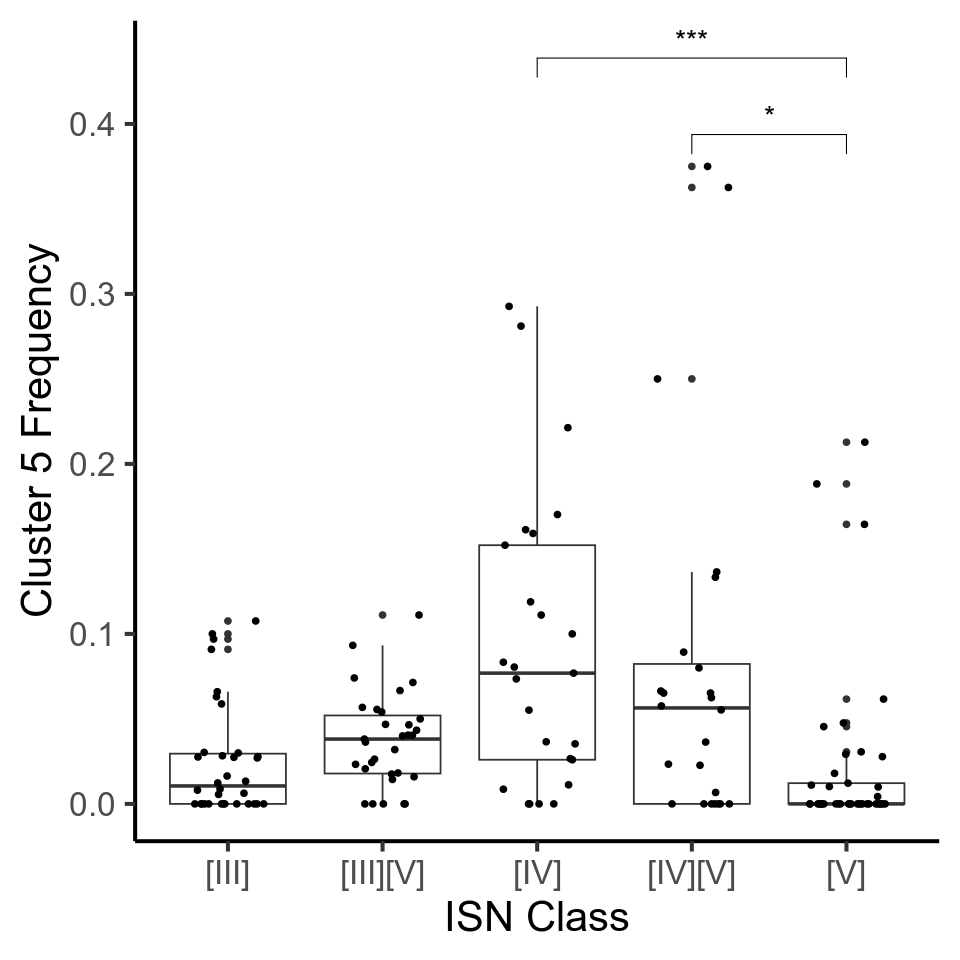

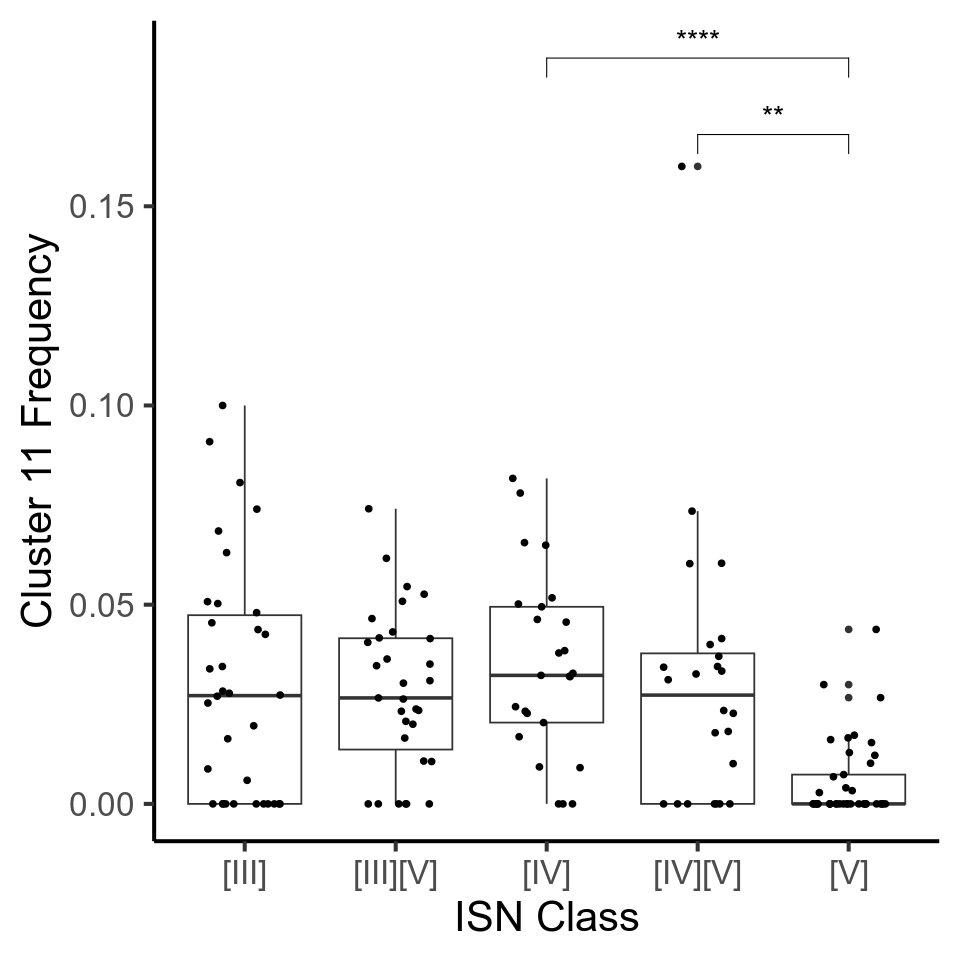

In [174]:
fig.size(8, 8)
my_comparisons <- list(c("[IV][V]", "[V]"),
                       c("[IV]", "[V]"))
ggplot(isn_df, aes(x = factor(Final_ISN), y = M0_Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 0 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

my_comparisons <- list(c("[IV][V]", "[V]"),
                       c("[IV]", "[V]"))
ggplot(isn_df, aes(x = factor(Final_ISN), y = M5_Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 5 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)
my_comparisons <- list(c("[IV][V]", "[V]"),
                       c("[IV]", "[V]"))
ggplot(isn_df, aes(x = factor(Final_ISN), y = M11_Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 11 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

# ISN CLASS IV and V Correlations

Warning message in geom_text(aes(label = label), size = 15, face = "bold"):
“Ignoring unknown parameters: `face`”
Warning message:
“Removed 9 rows containing missing values (`geom_text()`).”


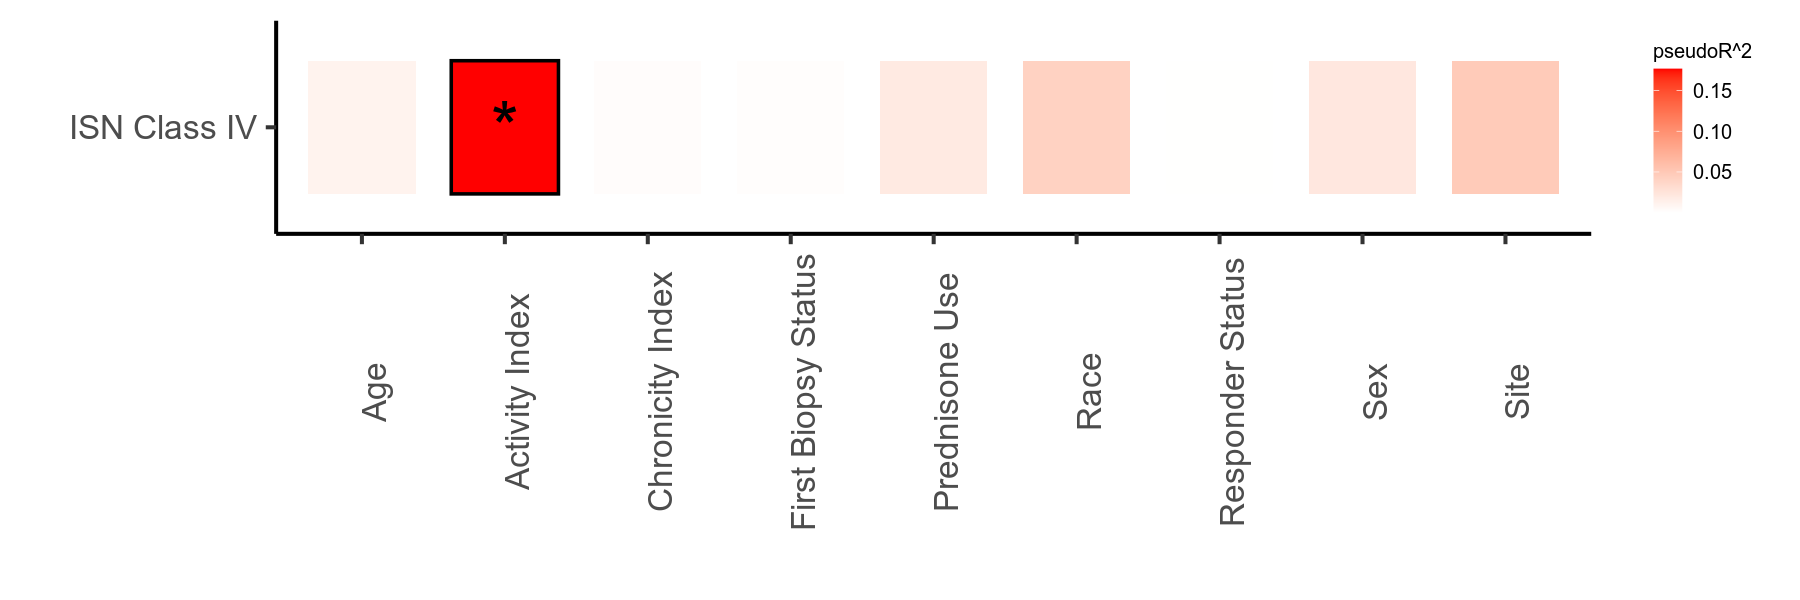

In [514]:
cor_df <- data.frame()
num_columns <- c('Final_Chronicity', 'Final_Activity',
                 'Pred_use', 'First_biop',
                 'Age', 'Sex', 'Responder_Status')
for (i in num_columns) {
    df <- clinical_LN %>% 
            select(Final_ISN_IV, i) %>% 
            na.omit()
    null_model <- glm(Final_ISN_IV ~ 1, 
            family = 'binomial',
            data = df)
    form <- paste0('Final_ISN_IV ~ ', i)
    fitted_model <- glm(form, 
            family = 'binomial',
            data = df)
    pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
    pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
    cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_IV', 
                               'Variable2' = i, 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))
}
df <- clinical_LN[, c('Final_ISN_IV', grep('Race', colnames(clinical_LN), value = TRUE))] %>% na.omit()
null_model <- glm(Final_ISN_IV ~ 1, data = df)
fitted_model <- glm(Final_ISN_IV ~ Race_A + Race_AB + Race_B + 
                                   Race_BAI + Race_BW + Race_U, data = df)
pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
    cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_IV', 
                               'Variable2' = 'Race', 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))
df <- clinical_LN[, c('Final_ISN_IV', grep('Race', colnames(clinical_LN), value = TRUE))] %>% na.omit()
null_model <- glm(Final_ISN_IV ~ 1, data = df)
fitted_model <- glm(Final_ISN_IV ~ Race_A + Race_AB + Race_B + 
                                   Race_BAI + Race_BW + Race_U, data = df)
pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_IV', 
                               'Variable2' = 'Race', 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))
df <- clinical_LN[, c('Final_ISN_IV', grep('Site', colnames(clinical_LN), value = TRUE))] %>% na.omit()
colnames(df) <- str_remove_all(colnames(df), "-")
colnames(df) <- str_remove_all(colnames(df), " ")
null_model <- glm(Final_ISN_IV ~ 1, data = df, family = 'binomial')
fitted_model <- glm(Final_ISN_IV ~ Final_Site_CedarsSinai + Final_Site_Cincinnati + 
                           Final_Site_Einstein + Final_Site_JHU + 
                           Final_Site_Michigan + Final_Site_MUSC + 
                           Final_Site_Northwell + Final_Site_NYU + 
                           Final_Site_Rochester + Final_Site_TexasTech + 
                           Final_Site_UCLA + Final_Site_UCSD, data = df,
                           family = 'binomial')
pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_IV', 
                               'Variable2' = 'Site', 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))

colnames(cor_df) <- c("Variable1", "Variable2", "correlation", "pvalue")
cor_df$bfpval <- p.adjust(cor_df$pvalue, method = 'bonferroni')

fig.size(5, 15)
ggplot(data = cor_df %>% mutate(label = ifelse(bfpval < 0.05, '*', NA)),
               aes(y = Variable1, x = Variable2, fill = as.numeric(correlation))) + 
    geom_tile(width = 0.75, height = 0.75) +
    geom_tile(data = cor_df %>% filter(pvalue < 0.05),
              color = "black", 
              width = 0.75, 
              height = 0.75,
              linewidth = 1) +
    geom_text(aes(label = label), size = 15, face = "bold") +  
    scale_fill_gradient2(low = "white",
                         high = "red") + 
    theme_classic(base_size = 25) + 
    labs(x = "", y = "", fill = "pseudoR^2") + 
    theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 12),
          axis.text.x = element_text(angle = 90)) +
    scale_y_discrete(labels = c("ISN Class IV")) + 
    scale_x_discrete(labels = c("Age", 'Activity Index',
                                'Chronicity Index',
                                'First Biopsy Status', 
                                'Prednisone Use', 'Race',
                                'Responder Status', 
                                'Sex', 'Site'))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in geom_text(aes(label = label), size = 15, face = "bold"):
“Ignoring unknown parameters: `face`”
Warning message:
“Removed 7 rows containing missing values (`geom_text()`).”


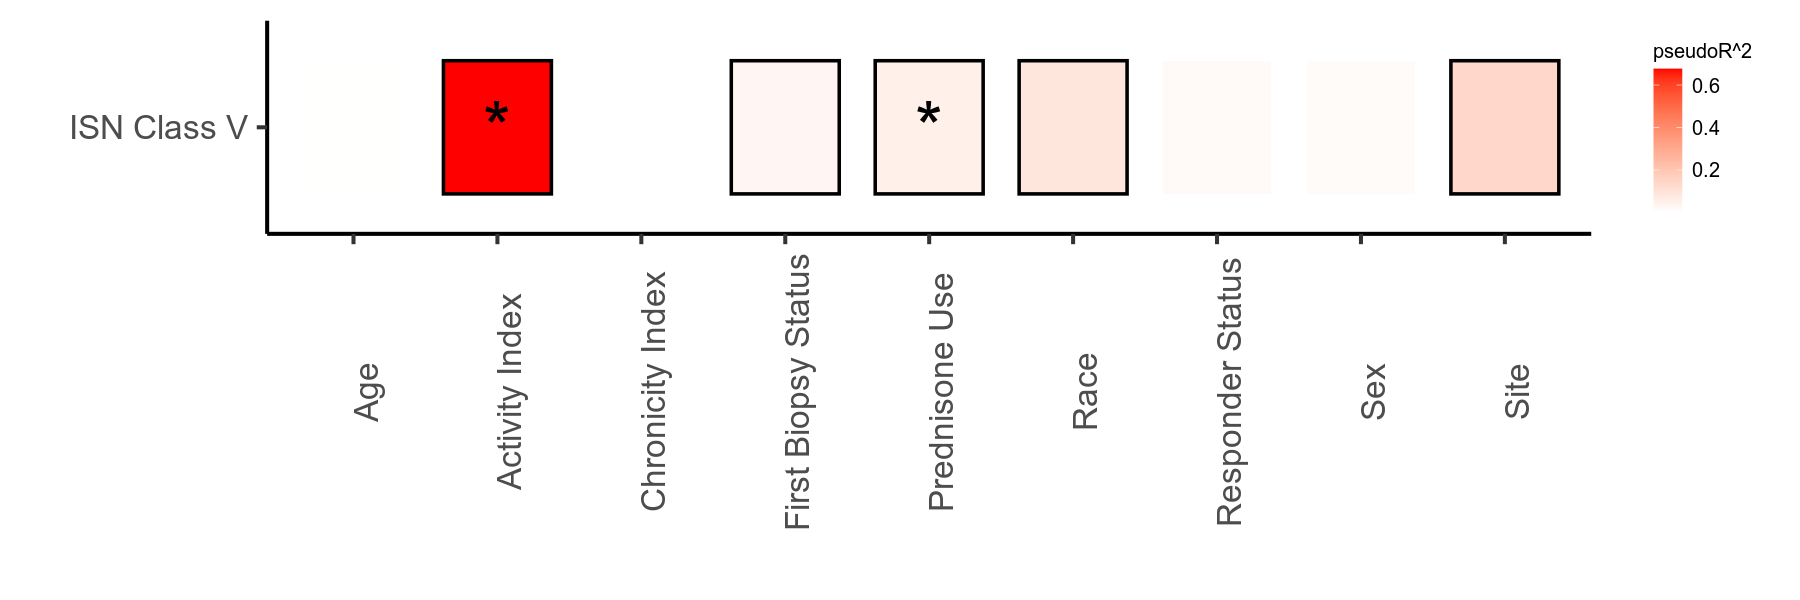

In [512]:
cor_df <- data.frame()
num_columns <- c('Final_Chronicity', 'Final_Activity',
                 'Pred_use', 'First_biop',
                 'Age', 'Sex', 'Responder_Status')
for (i in num_columns) {
    df <- clinical_LN %>% 
            select(Final_ISN_V, i) %>% 
            na.omit()
    null_model <- glm(Final_ISN_V ~ 1, 
            family = 'binomial',
            data = df)
    form <- paste0('Final_ISN_V ~ ', i)
    fitted_model <- glm(form, 
            family = 'binomial',
            data = df)
    pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
    pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
    cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_V', 
                               'Variable2' = i, 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))
}
df <- clinical_LN[, c('Final_ISN_V', grep('Race', colnames(clinical_LN), value = TRUE))] %>% na.omit()
null_model <- glm(Final_ISN_V ~ 1, data = df)
fitted_model <- glm(Final_ISN_V ~ Race_A + Race_AB + Race_B + 
                                   Race_BAI + Race_BW + Race_U, data = df)
pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
    cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_V', 
                               'Variable2' = 'Race', 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))
df <- clinical_LN[, c('Final_ISN_V', grep('Site', colnames(clinical_LN), value = TRUE))] %>% na.omit()
colnames(df) <- str_remove_all(colnames(df), "-")
colnames(df) <- str_remove_all(colnames(df), " ")
null_model <- glm(Final_ISN_V ~ 1, data = df, family = 'binomial')
fitted_model <- glm(Final_ISN_V ~ Final_Site_CedarsSinai + Final_Site_Cincinnati + 
                           Final_Site_Einstein + Final_Site_JHU + 
                           Final_Site_Michigan + Final_Site_MUSC + 
                           Final_Site_Northwell + Final_Site_NYU + 
                           Final_Site_Rochester + Final_Site_TexasTech + 
                           Final_Site_UCLA + Final_Site_UCSD, data = df,
                           family = 'binomial')
pvalue <- anova(null_model, fitted_model, test = "LRT")[2, 5]
pseudoR2 <- 1 - (fitted_model$deviance / fitted_model$null.deviance)
cor_df <- rbind(cor_df, 
                    data.frame('Variable1' = 'Final_ISN_V', 
                               'Variable2' = 'Site', 
                               'PseudoR2' = pseudoR2, 
                               'pvalue' = pvalue))

colnames(cor_df) <- c("Variable1", "Variable2", "correlation", "pvalue")
cor_df$bfpval <- p.adjust(cor_df$pvalue, method = 'bonferroni')

fig.size(5, 15)
ggplot(data = cor_df %>% mutate(label = ifelse(bfpval < 0.05, '*', NA)),
               aes(y = Variable1, x = Variable2, fill = as.numeric(correlation))) + 
    geom_tile(width = 0.75, height = 0.75) +
    geom_tile(data = cor_df %>% filter(pvalue < 0.05),
              color = "black", 
              width = 0.75, 
              height = 0.75,
              linewidth = 1) +
    geom_text(aes(label = label), 
              size = 15, face = "bold") + 
    scale_fill_gradient2(low = "white",
                         high = "red") + 
    theme_classic(base_size = 25) + 
    labs(x = "", y = "", fill = "pseudoR^2") + 
    theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 12),
          axis.text.x = element_text(angle = 90)) +
    scale_y_discrete(labels = c("ISN Class V")) + 
    scale_x_discrete(labels = c("Age", 'Activity Index',
                                'Chronicity Index',
                                'First Biopsy Status', 
                                'Prednisone Use', 'Race',
                                'Responder Status', 
                                'Sex', 'Site'))

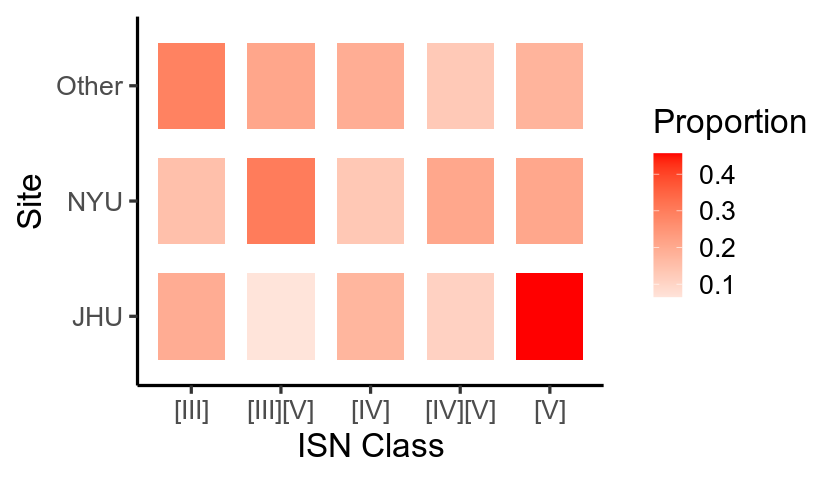

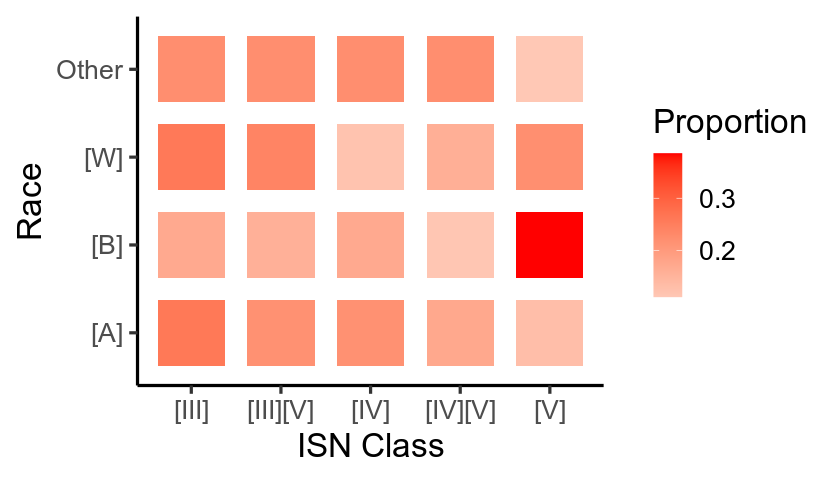

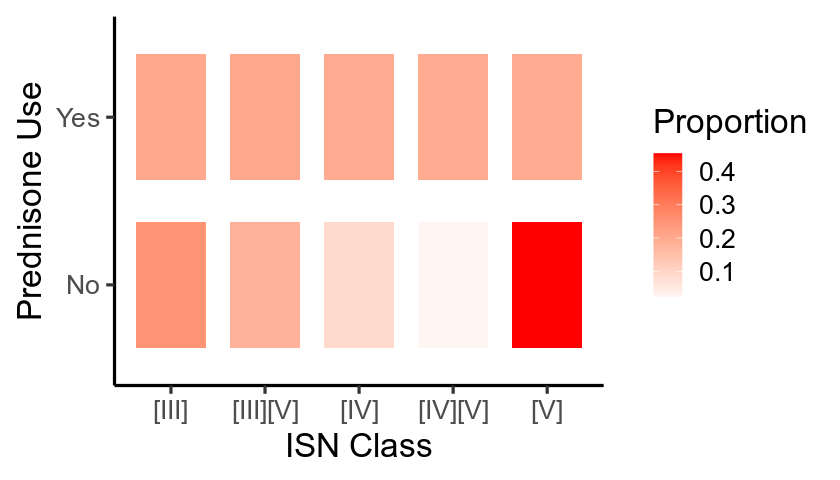

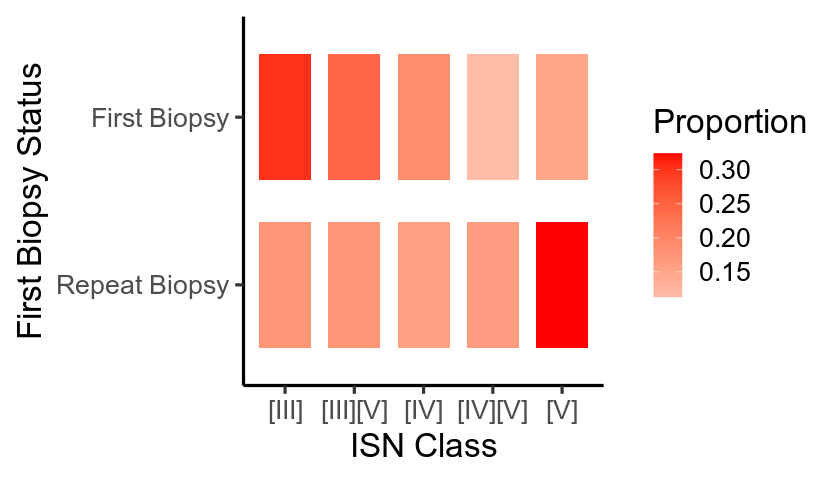

In [618]:
my_comparisons <- list(c("NYU", "JHU"))

clinical_LN <- clinical_LN %>% 
                    mutate(Renamed_Site = ifelse(Final_Site %in% c("NYU", "JHU"), Final_Site, "Other"))
fig.size(4, 7)

ggplot(clinical_LN %>% 
    select(Final_ISN, Renamed_Site) %>% 
    table() %>% prop.table(margin = 2) %>%
    data.frame(), aes(y = Renamed_Site, x = Final_ISN, fill = Freq)) + 
    geom_tile(width = 0.75, 
              height = 0.75) + 
    scale_fill_gradient2(low = "white", high = "red", name = "Proportion") +
    theme_classic(base_size = 20) + 
    labs(x = "ISN Class", y = "Site")


clinical_LN <- clinical_LN %>%
                mutate(Renamed_Race = 
                       ifelse(Race %in% c("[A]", "[B]", "[W]"), Race, "Other"))
fig.size(4, 7)

ggplot(clinical_LN %>% 
    select(Final_ISN, Renamed_Race) %>% 
    table() %>% prop.table(margin = 2) %>%
    data.frame(), aes(x = Final_ISN, y = Renamed_Race, fill = Freq)) + 
    geom_tile(width = 0.75, 
              height = 0.75) + 
    scale_fill_gradient2(low = "white", high = "red", name = "Proportion") +
    theme_classic(base_size = 20) + 
    labs(x = "ISN Class", y = "Race")


ggplot(clinical_LN %>% 
    select(Final_ISN, Pred_use) %>% 
    table() %>% prop.table(margin = 2) %>%
    data.frame(), aes(x = Final_ISN, y = Pred_use, fill = Freq)) + 
    geom_tile(width = 0.75, 
              height = 0.75) + 
    scale_fill_gradient2(low = "white", high = "red", name = "Proportion") +
    theme_classic(base_size = 20) +
    scale_y_discrete(labels = c("No", "Yes")) + 
    labs(x = "ISN Class", y = "Prednisone Use")

ggplot(clinical_LN %>% 
    select(Final_ISN, First_biop) %>% 
    table() %>% prop.table(margin = 2) %>%
    data.frame(), aes(x = Final_ISN, y = First_biop, fill = Freq)) + 
    geom_tile(width = 0.75, 
              height = 0.75) + 
    scale_fill_gradient2(low = "white", high = "red", name = "Proportion") +
    theme_classic(base_size = 20) +
    scale_y_discrete(labels = c("Repeat Biopsy", "First Biopsy")) + 
    labs(x = "ISN Class", y = "First Biopsy Status")

In [73]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/Myeloid_clusterQCd_meta_harmonizedPCUMAPCellStateClusters_10042022.rds')
prop_table <- qcd_meta %>% filter(dataset == "scRNAseq") %>% 
                group_by(new_cluster_number) %>% 
                select(sample, new_cluster_number) %>% 
                table() %>% prop.table(margin = 1) %>% data.frame()
prop_table <- prop_table %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3])

In [77]:
colnames(clinical_LN) <- str_remove_all(str_remove_all(colnames(clinical_LN), "\\["), "\\]")
prop_table <- prop_table %>% 
                left_join(clinical_LN %>% 
                            select(individual, Final_ISN), by = 'individual') %>% 
                na.omit()

[1] FALSE
[1] FALSE


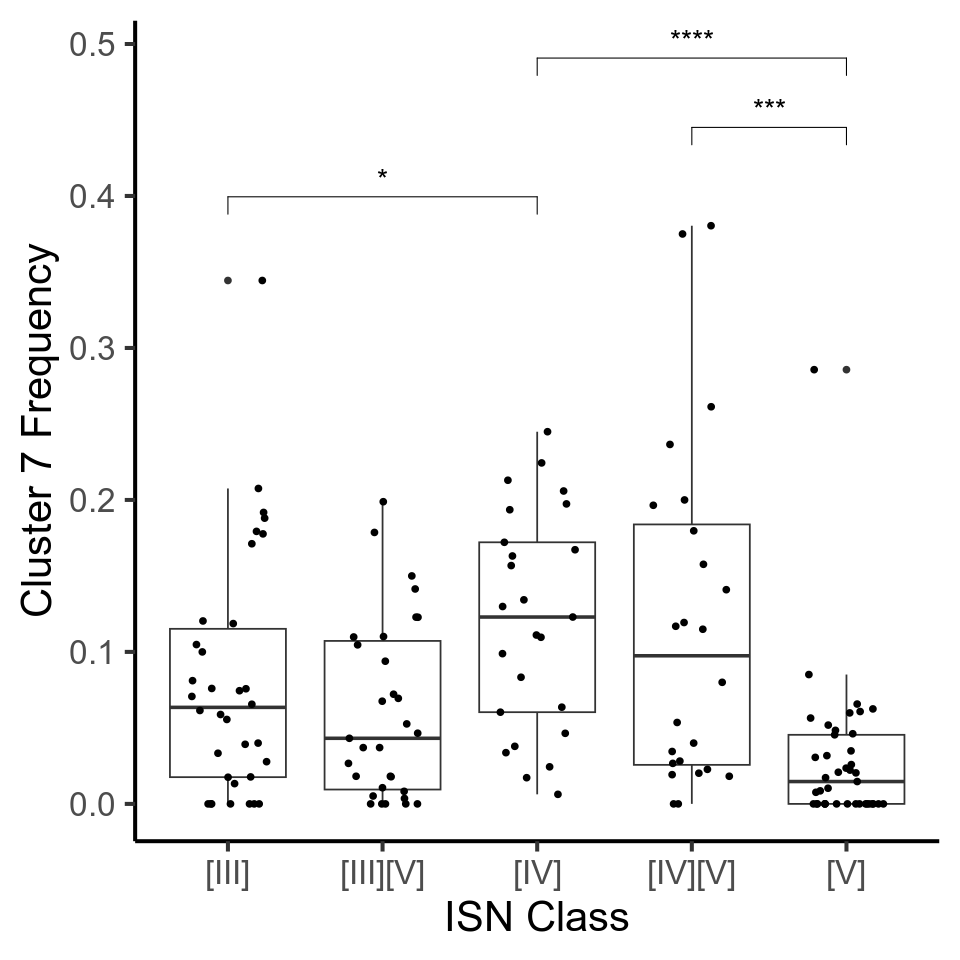

[1] FALSE


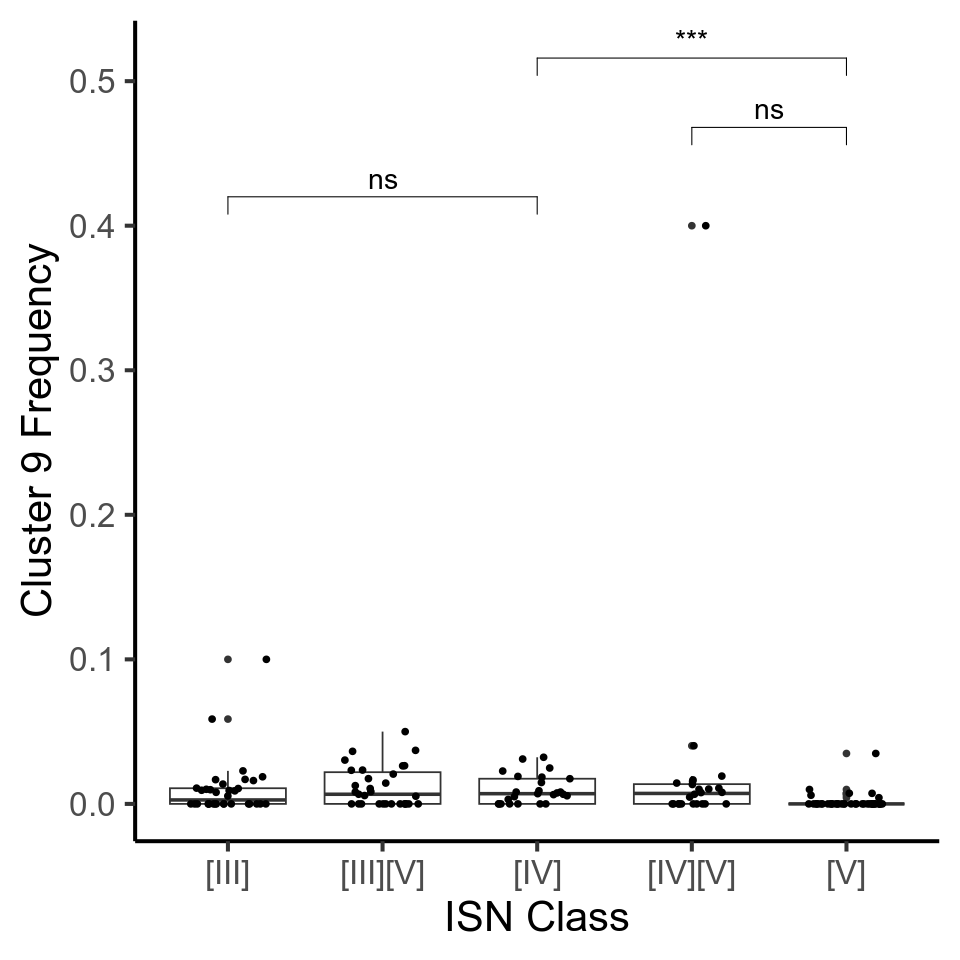

[1] FALSE


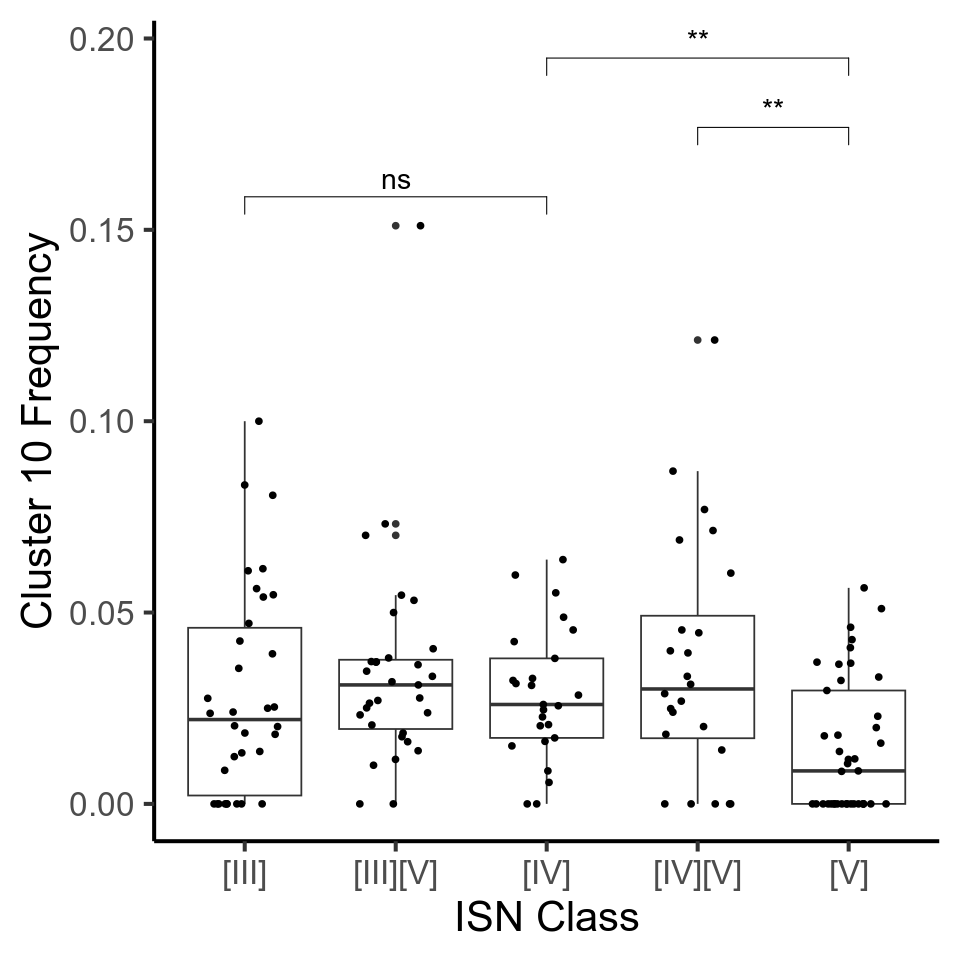

[1] FALSE


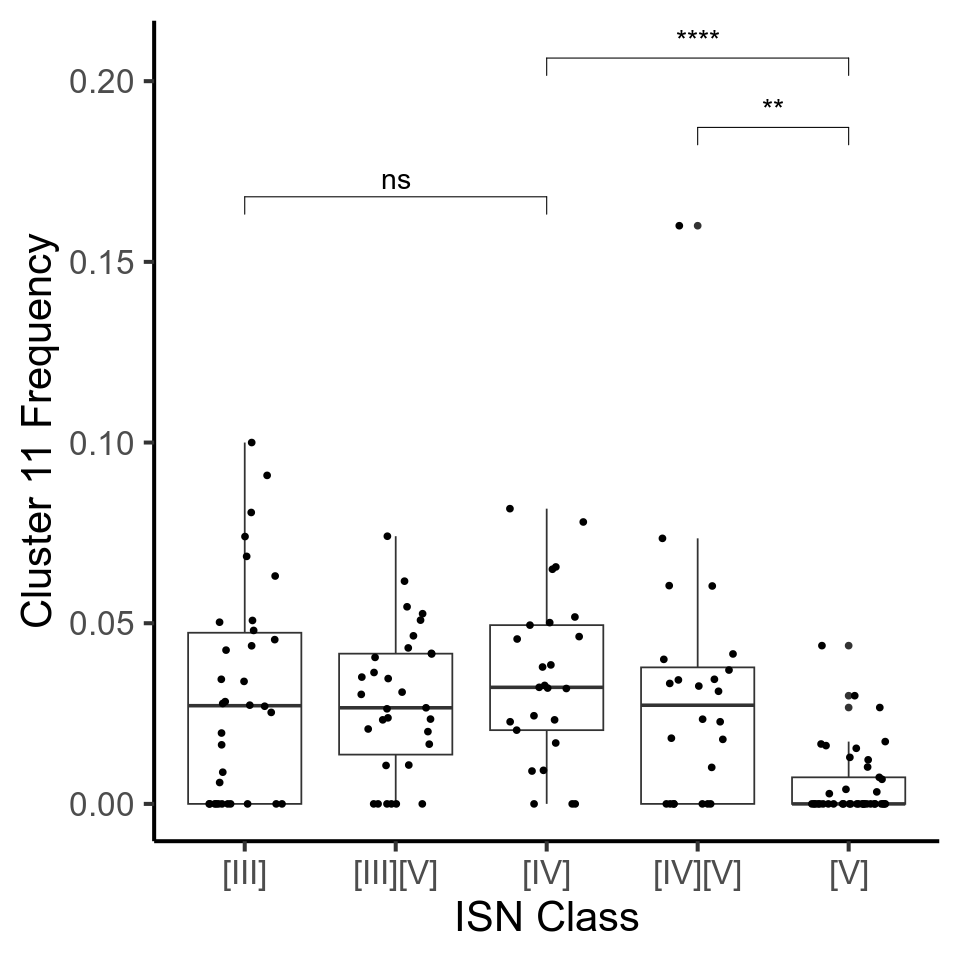

[1] FALSE


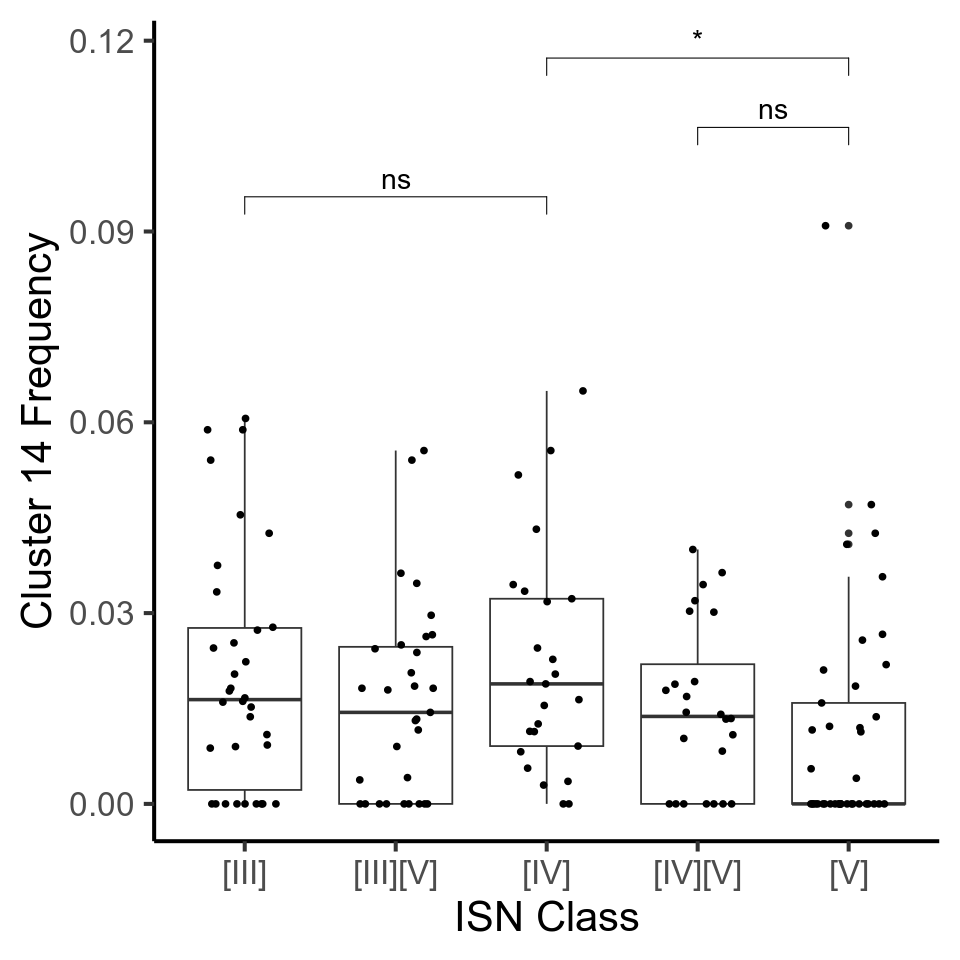

[1] FALSE


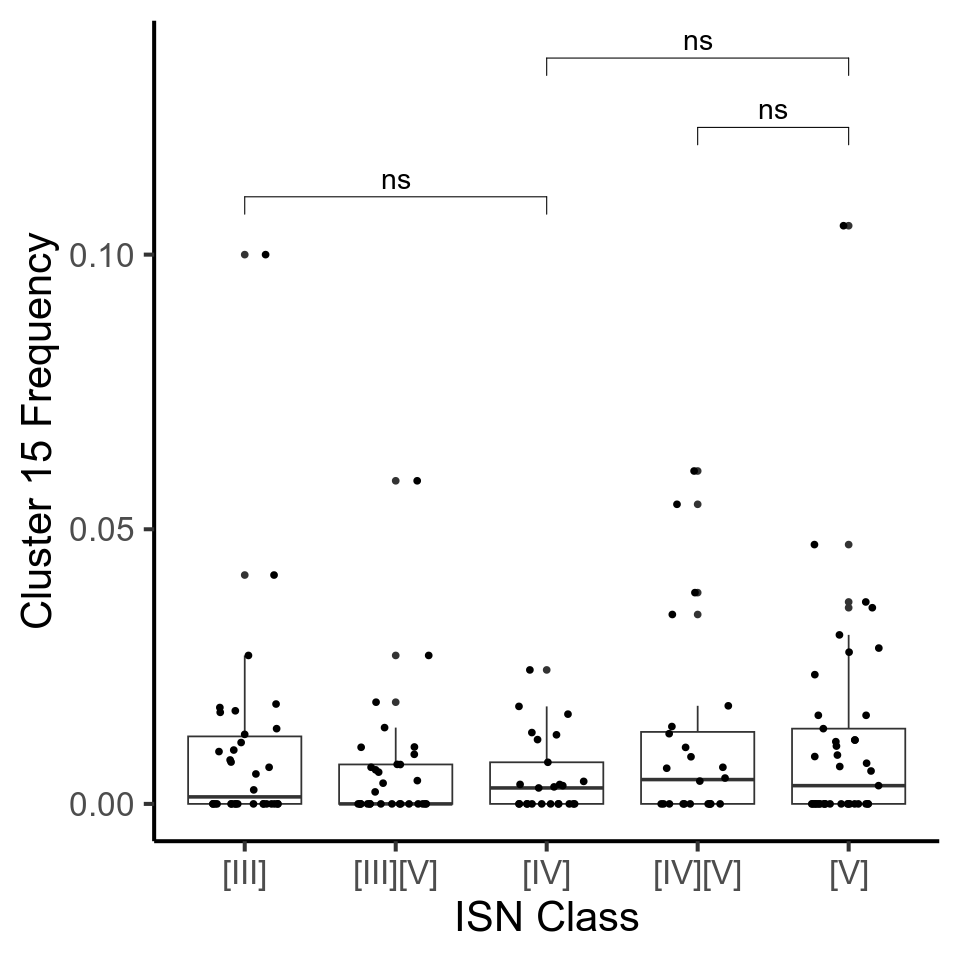

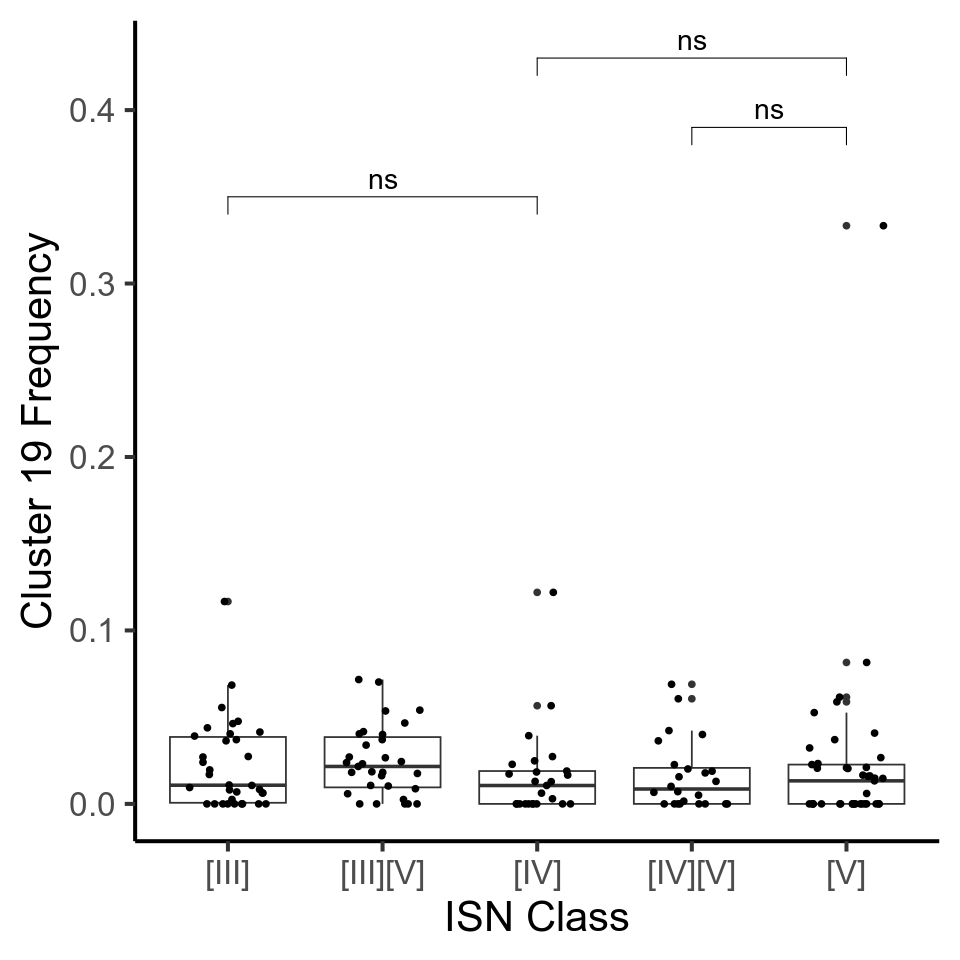

In [96]:
fig.size(8, 8)

my_comparisons <- list(c("[III]", "[IV]"),
                       c("[IV][V]", "[V]"),
                       c("[IV]", "[V]"))
ggplot(prop_table %>% 
        filter(new_cluster_number == 7), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 7 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 9), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 9 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 10), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 10 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 11), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 11 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 14), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 14 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 15), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 15 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 19), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 19 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

# TABLE 1

In [6]:
clinical_LN <- clinical %>% filter(Type == "LN") 

In [218]:
write.table(clinical_LN %>% pull(AMP.Subject_ID), "/data/srlab/ssg34/SLE_kidney_v2/data/all_lupus_samples.txt",sep = "\t", 
            quote = FALSE, col.names = FALSE, row.names = FALSE)

In [79]:
clinical_control <- clinical %>% filter(Type != "LN") %>% filter(individual %in% all_immune_meta$individual)

In [ ]:
med_use <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/meds_scRNA_kidney.csv') %>% mutate(individual = gsub("SLE", "", patientID))

In [ ]:
saveRDS(clinical_LN, '/data/srlab/ssg34/SLE_kidney_v2/data/LN_clinicaldata_05232023.rds')

In [545]:
saveRDS(clinical_control, '/data/srlab/ssg34/SLE_kidney_v2/data/control_clinicaldata_05232023.rds')

In [2]:
clinical_LN <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/LN_clinicaldata_05232023.rds')
clinical_control <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/control_clinicaldata_05232023.rds')

In [544]:
clinical_LN <- fastDummies::dummy_cols(clinical_LN, "Race")

In [563]:
clinical_LN <- fastDummies::dummy_cols(clinical_LN, "Ethnicity")

In [546]:
clinical_control <- fastDummies::dummy_cols(clinical_control, "Race")

In [564]:
clinical_control <- fastDummies::dummy_cols(clinical_control, "Ethnicity")

In [569]:
t.test(clinical_LN %>% pull("Ethnicity_Hispanic or Latino"), clinical_LN %>% filter(Final_ISN %in% c("[V]")) %>% pull("Ethnicity_Hispanic or Latino"))


	Welch Two Sample t-test

data:  clinical_LN %>% pull("Ethnicity_Hispanic or Latino") and clinical_LN %>% filter(Final_ISN %in% c("[V]")) %>% pull("Ethnicity_Hispanic or Latino")
t = 0.85978, df = 66.807, p-value = 0.393
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.08505967  0.21377722
sample estimates:
mean of x mean of y 
0.2838710 0.2195122 


In [573]:
t.test(clinical_LN %>% pull("Ethnicity_Hispanic or Latino"), clinical_control %>% pull("Ethnicity_Hispanic or Latino"))


	Welch Two Sample t-test

data:  clinical_LN %>% pull("Ethnicity_Hispanic or Latino") and clinical_control %>% pull("Ethnicity_Hispanic or Latino")
t = 5.0812, df = 109.69, p-value = 1.552e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1528199 0.3482553
sample estimates:
 mean of x  mean of y 
0.28387097 0.03333333 


In [572]:
t.test(clinical_LN %>% pull("Ethnicity_Hispanic or Latino"), clinical_LN %>% filter(Final_ISN %in% c("[IV][V]", "[III][V]")) %>% pull("Ethnicity_Hispanic or Latino"))


	Welch Two Sample t-test

data:  clinical_LN %>% pull("Ethnicity_Hispanic or Latino") and clinical_LN %>% filter(Final_ISN %in% c("[IV][V]", "[III][V]")) %>% pull("Ethnicity_Hispanic or Latino")
t = -0.59078, df = 91.273, p-value = 0.5561
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1893262  0.1025227
sample estimates:
mean of x mean of y 
0.2838710 0.3272727 


In [585]:
med_clinical_ln <- clinical_LN %>% select('CS_above10', 'MMF', 'CYC', 'AZA', 'TAC', 'MTX', 'BEL', 'HCQ', 'Final_ISN')

In [586]:
med_clinical_ln

CS_above10,MMF,CYC,AZA,TAC,MTX,BEL,HCQ,Final_ISN
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,1,0,0,0,0,0,1,[III]
0,0,0,1,0,0,0,1,[III]
0,0,0,0,0,0,0,1,[III][V]
1,0,0,0,0,0,0,0,[III][V]
0,0,0,0,0,0,0,0,[V]
1,0,0,1,0,0,0,0,[V]
1,1,0,0,0,0,0,1,[IV]
0,0,0,0,0,0,0,1,[III]
0,1,0,0,0,0,0,1,[III]


In [578]:
colnames(clinical_LN)

[1] "AMP.ID"                        "Final_Site"                   
 [3] "Clinical.Response.at.12.weeks" "Clinical.Response.at.26.weeks"
 [5] "Clinical.Response.at.52.weeks" "Responder.Status"             
 [7] "Type"                          "Sex"                          
 [9] "Age"                           "Race"                         
[11] "Ethnicity"                     "ISN"                          
[13] "Activity"                      "Chronicity"                   
[15] "sample"                        "processing.date"              
[17] "processing.batch"              "XTR.WTA.batch"                
[19] "LCSET.lib.construction.batch"  "DASH.batch"                   
[21] "our.photo.length.mm"           "yield"                        
[23] "cells.loaded"                  "cDNA.yield.ng.uL"             
[25] "index"                         "seq.submission.date"          
[27] "Novaseq.num"                   "Flow.cell"                    
[29] "Lane.num"                      "Rituximab.stop.date"          
[31] "biopsy.length.from.site.mm"    "Age.at.1st.nephritis.episode" 
[33] "dsdna"                         "ana"                          
[35] "antism"                        "antirnp"                      
[37] "antiro"                        "antila"                       
[39] "c3"                            "c4"                           
[41] "ch50"                          "individual"                   
[43] "AMP.Subject_ID"                "Central_ISN"                  
[45] "Central_Activity"              "Central_Chronicity"           
[47] "Final_ISN"                     "Final_Chronicity"             
[49] "Final_Activity"                "patientID"                    
[51] "visit"                         "visit_date"                   
[53] "condition"                     "HCQ"                          
[55] "CS"                            "CS_pulse"                     
[57] "CS_dose"                       "CS_dose_all"                  
[59] "CS_above10"                    "MMF"                          
[61] "CYC"                           "AZA"                          
[63] "TAC"                           "MTX"                          
[65] "BEL"                           "Sex_numeric"                  
[67] "Race_[A]"                      "Race_[A][B]"                  
[69] "Race_[B]"                      "Race_[B][AI]"                 
[71] "Race_[B][W]"                   "Race_[U]"                     
[73] "Race_[W]"                      "Ethnicity_Hispanic or Latino" 
[75] "Ethnicity_Not Hispanic"

# UNIFIED DE

In [5]:
tnk_de <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/TNK_case_control_differential_expression_120722023.rds')
tnk_de <- tnk_de %>% na.omit() 
tnk_de <- tnk_de %>% filter(LRP < 0.05/nrow(tnk_de)) %>% select(Beta, gene, SE) %>% mutate(cell_type = "T/NK")
myeloid_de <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/Myeloid_case_control_differential_expression_120722023.rds')
myeloid_de <- myeloid_de %>% na.omit() 
myeloid_de <- myeloid_de %>% filter(LRP < 0.05/nrow(myeloid_de)) %>% select(Beta, gene, SE) %>% mutate(cell_type = "Myeloid")

In [6]:
de_df <- rbind(tnk_de, myeloid_de)

In [16]:
intersect(tnk_de %>% pull(gene), myeloid_de %>% pull(gene))

[1] "ISG15"      "IFI6"       "SMAP2"      "IFI44L"     "TXNIP"     
 [6] "ARHGEF2"    "RGS1"       "RAB29"      "PDIA6"      "RPS27A"    
[11] "NAT8"       "CXCR4"      "CYTIP"      "STAT1"      "SPATS2L"   
[16] "EEF1B2"     "PARP14"     "GPR171"     "RPL9"       "HNRNPDL"   
[21] "HMGB2"      "RPS14"      "HLA-A"      "PPP1R10"    "FKBP5"     
[26] "PHACTR2"    "ARMT1"      "SYTL3"      "TOMM7"      "BLVRA"     
[31] "SAMD9L"     "AP1S1"      "PDIA4"      "SARAF"      "SLA"       
[36] "LY6E"       "KLF9"       "CELF2"      "OPTN"       "ANAPC16"   
[41] "DDIT4"      "STIP1"      "RPS3"       "ZBTB16"     "BTG1"      
[46] "AC025164.1" "DYNLL1"     "EPSTI1"     "TPT1"       "NFKBIA"    
[51] "AL627171.1" "GABPB1-IT1" "SOCS1"      "PER1"       "SSH2"      
[56] "MRPL27"     "LGALS3BP"   "PSTPIP2"    "BST2"       "WFDC2"     
[61] "CEBPB"      "EVA1C"      "RBM3"       "TSC22D3"

In [20]:
genes <- c("CXCR4", "FKBP5", "ZBTB16", "NFKBIA", "KLF9", 
           "ISG15", "STAT1", "LY6E", "BST2", "PARP14")

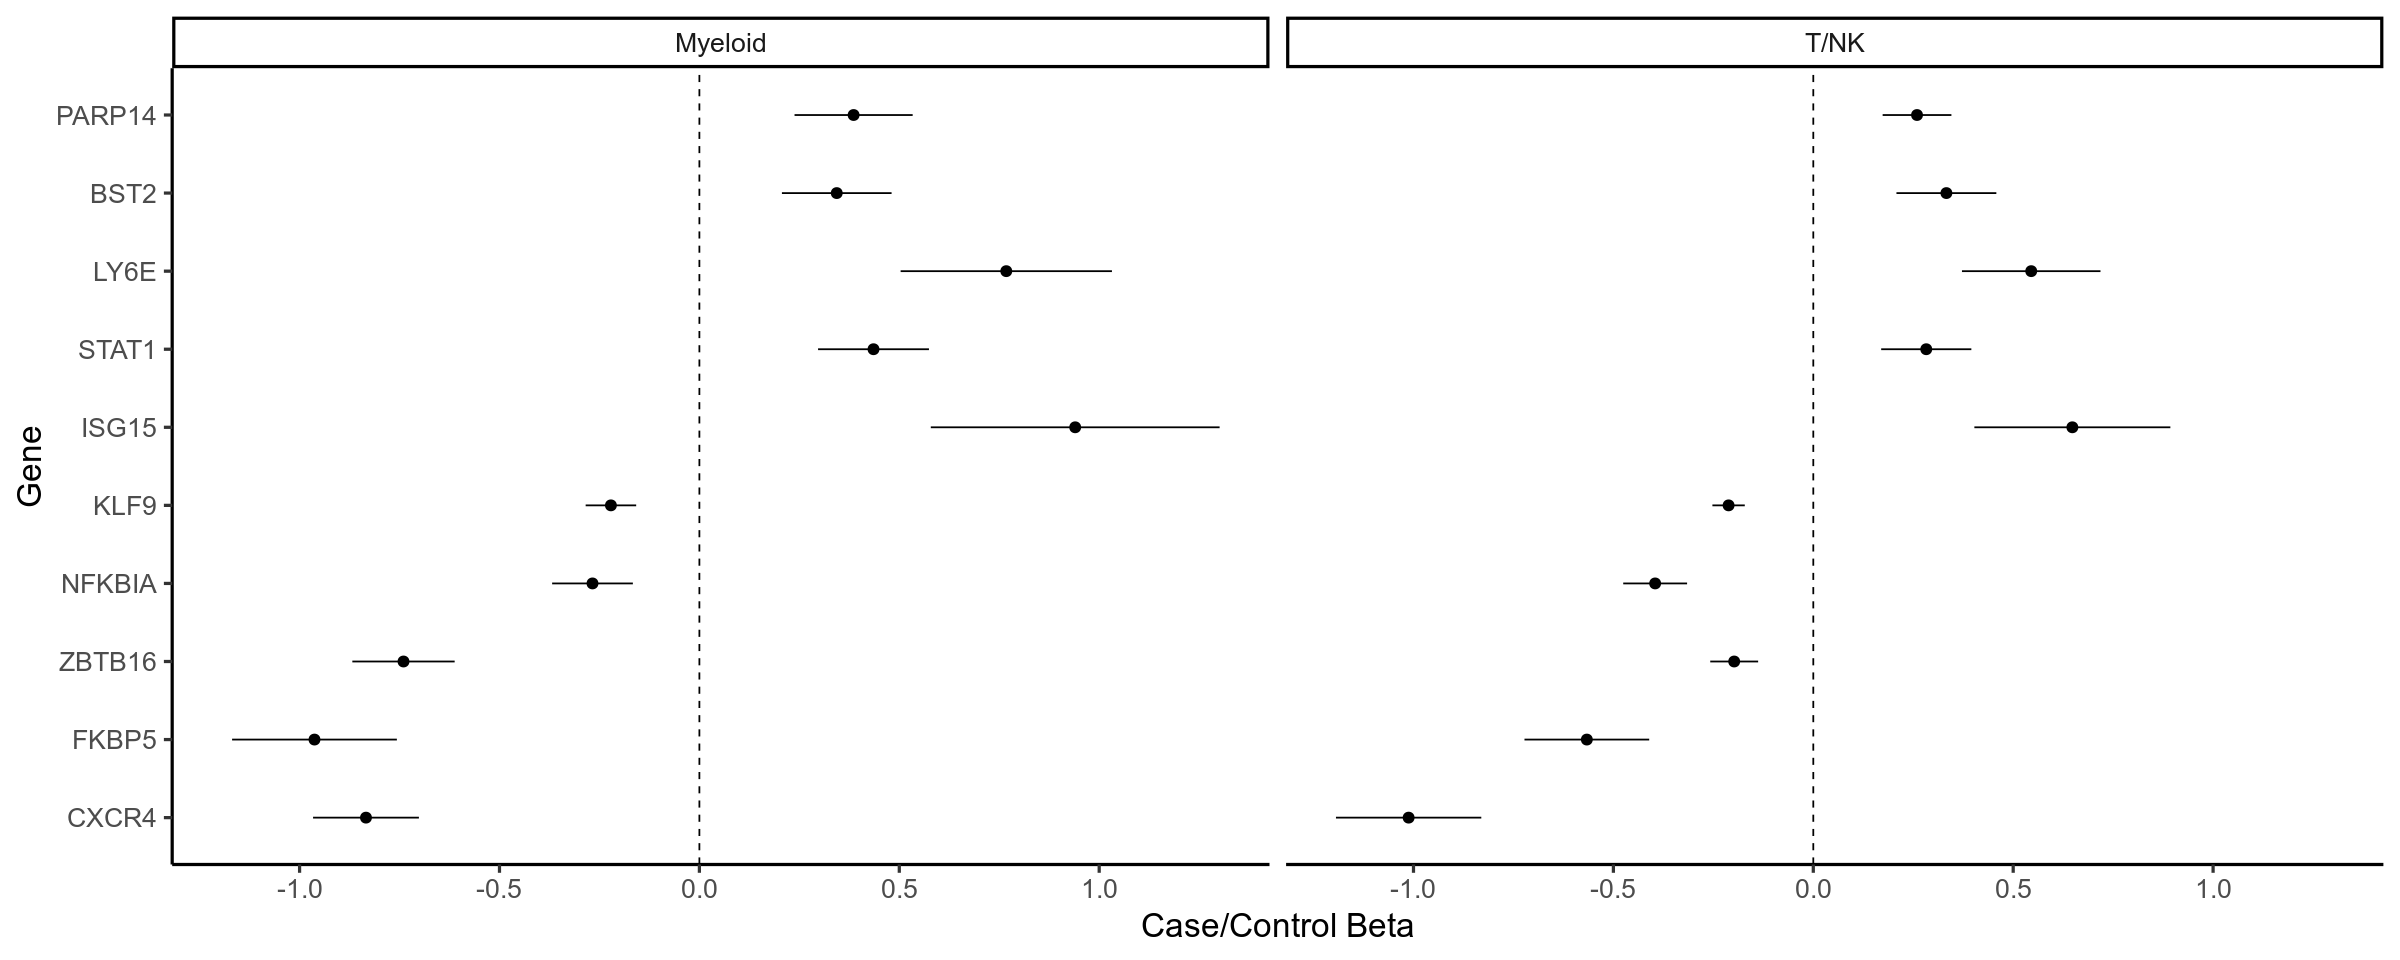

In [21]:
fig.size(8, 20)
ggplot(de_df %>% filter(gene %in% genes) %>% arrange(Beta), aes(x = Beta, y = gene)) + 
    geom_pointrange(aes(xmin = Beta - 1.96 * SE, xmax = Beta + 1.96 * SE)) + 
    facet_grid(cols = vars(cell_type)) + 
    theme_classic(base_size = 20) + 
    geom_vline(aes(xintercept = 0), linetype = "dashed") + 
    scale_y_discrete(limits = genes) + labs(x = "Case/Control Beta", y = "Gene")